In [ ]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats
import numpy as np
import seaborn as sns
from sklearn import datasets, metrics, neighbors, decomposition, manifold, svm
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from IPython.display import Image
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

%matplotlib inline 
np.random.seed(314158)

debug = False

# M1

Leamos los archivos y obtengamos  todos los DataFrames.

In [ ]:
data = {}
for i in range(2014, 2019):
    print(i)
    data[i] = pd.read_csv(f'{i}_Financial_data.csv')

2014
2015
2016
2017
2018


Revisemos las columnas y veamos si tenemos que eliminar alguna.

In [ ]:
pos = list(data[2015].columns)
print(pos)
pos = pos[1:-2]

['Unnamed: 0', 'Revenue', 'Revenue Growth', 'Cost of Revenue', 'Gross Profit', 'R&D Expenses', 'SG&A Expense', 'Operating Expenses', 'Operating Income', 'Interest Expense', 'Earnings before Tax', 'Income Tax Expense', 'Net Income - Non-Controlling int', 'Net Income - Discontinued ops', 'Net Income', 'Preferred Dividends', 'Net Income Com', 'EPS', 'EPS Diluted', 'Weighted Average Shs Out', 'Weighted Average Shs Out (Dil)', 'Dividend per Share', 'Gross Margin', 'EBITDA Margin', 'EBIT Margin', 'Profit Margin', 'Free Cash Flow margin', 'EBITDA', 'EBIT', 'Consolidated Income', 'Earnings Before Tax Margin', 'Net Profit Margin', 'Cash and cash equivalents', 'Short-term investments', 'Cash and short-term investments', 'Receivables', 'Inventories', 'Total current assets', 'Property, Plant & Equipment Net', 'Goodwill and Intangible Assets', 'Long-term investments', 'Tax assets', 'Total non-current assets', 'Total assets', 'Payables', 'Short-term debt', 'Total current liabilities', 'Long-term deb

Revisemos los datos de las siguientes columnas:
- Net cash flow / Change in cash
- EPS Diluted
- Weighted Average Shs Out
- Net Income
- Gross Margin
- EPS
- Net Profit Margin
- EBIT Margin
- Consolidated Income
- Sector

In [ ]:
# elegi estas columnas tras un pequenho proceso de seleccion. La idea fue que sean interesantes, bien distribuidas y utiles despues para los modelos de prediccion. 
columns = ['Net cash flow / Change in cash','EPS Diluted','Weighted Average Shs Out','Net Income','Gross Margin','EPS','Net Profit Margin','EBIT Margin','Consolidated Income', 'Sector']

In [ ]:
# revisemos cuanto datos tenemos y cuantos ourliers tenemos en cada una de las columnas

outliers = defaultdict(int)
cant = defaultdict(int)
for y in range(2014, 2018):
    for k in columns:
        d = data[y][k][:-1]
        cant[k] += int(d.describe()['count'])
        if k == 'Sector':
            outliers[k] = 0
            continue
        Q1 = d.quantile(0.25)
        Q3 = d.quantile(0.75)
        R = Q3 - Q1
        outliers[k] += ((d < (Q1 - 1.5*R)) | (d > (Q3 + 1.5*R))).sum()

In [ ]:
# vamos a revisar las caracteristicas de los datos.
for k in columns:
    print(k)
    df = pd.concat([data[2014][k], data[2015][k], data[2016][k], data[2017][k]])
    info = df.describe()
    print(info)
    print()

    if k != 'Sector': # sector al ser cualitativo no tiene std, mena ni cuantiles.
        print(f'normalized std: {info["std"] / abs(info["mean"])}')
        print(f'percentile skewness: {(df.quantile(.9)-df.quantile(.5))/(df.quantile(.5) - df.quantile(.1))}')
    print(f'outliers: {outliers[k]}')
    print(f'Total Data in 4 years: {cant[k]}')
    print(f'Percentage of outliers: {round(outliers[k]/cant[k]*100)}%')
    print()
    print()

Net cash flow / Change in cash
count    1.669100e+04
mean     2.859670e+07
std      2.663943e+10
min     -9.880000e+11
25%     -1.521600e+07
50%      7.960000e+05
75%      2.986950e+07
max      9.880000e+11
Name: Net cash flow / Change in cash, dtype: float64

normalized std: 931.5559286555326
percentile skewness: 1.4767530661981312
outliers: 4220
Total Data in 4 years: 16687
Percentage of outliers: 25%


EPS Diluted
count    1.645600e+04
mean    -1.354125e+04
std      1.006232e+06
min     -1.018709e+08
25%     -3.900000e-01
50%      6.200000e-01
75%      1.915800e+00
max      6.624003e+06
Name: EPS Diluted, dtype: float64

normalized std: 74.30859388639583
percentile skewness: 1.0256410256410255
outliers: 2077
Total Data in 4 years: 16452
Percentage of outliers: 13%


Weighted Average Shs Out
count    1.625700e+04
mean     2.621989e+08
std      2.051678e+09
min      0.000000e+00
25%      1.677013e+07
50%      4.300000e+07
75%      1.158548e+08
max      1.112919e+11
Name: Weighted Aver

- Dentro de los datos, podemos apreciar que en general no tenemos datos demasiado "tirados a un lado" (aka. skewed), lo que nos debería servir para asimilarnos mas a una normal, la cual como se dijo en clases, tiende a ser beneficiosa para este tipo de trabajos.
- también podemos ver que en general la desviación normalizada tiende a ser bastante grande. Esto nos indica que los datos están más bien repartidos, lo que debería ayudarnos a generar diferenciación cuando tengamos que hacer los modelos después. Si tenemos todos los datos juntos va a ser difícil diferenciar las clases.
- Por otro lado, no tenemos demasiados outliers, lo que nos quita un poco de ruido de los datos.
- Finalmente, es importante que en todos tenemos una gran cantidad de datos, lo que nos va a permitir tener menos ruido, para los modelos, cuando limpiemos los datos.

# M2

In [ ]:
anhos = [2014, 2015, 2016, 2017]
data = {}
for i in range(2014, 2019):
    print(i)
    data[i] = pd.read_csv(f'{i}_Financial_data.csv')

2014
2015
2016
2017
2018


In [ ]:
# Cambiemos las tablas a unicamente las columnas que nos interesan. Y cambiemosle el nombre a la varacion para que quede en todos igual.
data_pruned = dict()
for k in data:
    data_pruned[k] = data[k][columns + [f'{k+1} PRICE VAR [%]', 'Class']]
    data_pruned[k].columns = ['Net cash flow / Change in cash', 'EPS Diluted', 'Weighted Average Shs Out', 'Net Income', 'Gross Margin', 'EPS', 'Net Profit Margin', 'EBIT Margin', 'Consolidated Income', 'Sector', 'Price Var', 'Class']

In [ ]:
# intentemos eliminar las entreadas que tienen outliers
n = 2
for k in anhos:
    d = data_pruned[k].copy()
    print(d.shape)
    print()
    for v in columns[:-1]:
        Q1 = d[v].quantile(0.25)
        Q3 = d[v].quantile(0.75)
        R = Q3 - Q1
        d = d[(((Q1 - n*R) < d[v]) & (d[v] < (Q3 + n*R)))]
    print(d.shape)
    print()
    print('-'*30)
    print()


(3808, 12)

(1653, 12)

------------------------------

(4120, 12)

(1727, 12)

------------------------------

(4797, 12)

(1839, 12)

------------------------------

(4960, 12)

(1969, 12)

------------------------------



como podemos ver, eliminamos muchos ejemplos. Esto no es factible ya que nos vamos a quedar con un dataset mucho mas pequeño y eso va a terminar siendo perjudicial.

In [ ]:
# revisemos la cantidad de nans que tenemos
pd.isna(pd.concat([data_pruned[2014], data_pruned[2015], data_pruned[2016], data_pruned[2017]])).value_counts()

Net cash flow / Change in cash  EPS Diluted  Weighted Average Shs Out  Net Income  Gross Margin  EPS    Net Profit Margin  EBIT Margin  Consolidated Income  Sector  Price Var  Class
False                           False        False                     False       False         False  False              False        False                False   False      False    15717
True                            True         True                      True        True          True   True               True         True                 False   False      False      900
False                           False        False                     True        False         False  True               True         True                 False   False      False      280
                                             True                      False       False         False  False              False        False                False   False      False      216
                                True         True     

Podemos ver que la mayoria de las entradas con problemas no tienen ningún atributo mas que sector, estas claramente no nos sirven ya que no podemos adivinar 9 features de solo el sector. Del resto, tenemos tres filas que nos indican que hay ejemplos con 1 datos faltantes en una sola columna. Weighted Average Shs Out, Net cash flow, EPS Diluted. Vamos a llenar estos datos y omitir las entradas que tienen mas de 1 feature faltante, ya que esto generaria demasiado ruido en nuestros datos. 

In [ ]:
for k in anhos:
    print(data_pruned[k].shape)
    data_pruned[k] = data_pruned[k].dropna(thresh=11)
    print(data_pruned[k].shape)
    print()
pd.isna(pd.concat([data_pruned[2014], data_pruned[2015], data_pruned[2016], data_pruned[2017]])).value_counts()

(3808, 12)
(3706, 12)

(4120, 12)
(3892, 12)

(4797, 12)
(4119, 12)

(4960, 12)
(4254, 12)



Net cash flow / Change in cash  EPS Diluted  Weighted Average Shs Out  Net Income  Gross Margin  EPS    Net Profit Margin  EBIT Margin  Consolidated Income  Sector  Price Var  Class
False                           False        False                     False       False         False  False              False        False                False   False      False    15717
                                             True                      False       False         False  False              False        False                False   False      False      216
True                            False        False                     False       False         False  False              False        False                False   False      False       24
False                           True         False                     False       False         False  False              False        False                False   False      False       14
dtype: int64

Obtengamos la informacion, creemos los predictores para las variables que faltan y arreglemos los datos.

In [ ]:
data = pd.concat([data_pruned[2014], data_pruned[2015], data_pruned[2016], data_pruned[2017]])
data = data.dropna()
cash = data['Net cash flow / Change in cash']
EPSd = data['EPS Diluted']
average = data['Weighted Average Shs Out']
data = data[['Net Income', 'Gross Margin', 'EPS', 'Net Profit Margin', 'EBIT Margin', 'Consolidated Income', 'Sector', 'Price Var', 'Class']]
data.shape, cash.shape, EPSd.shape, average.shape

((15717, 9), (15717,), (15717,), (15717,))

In [ ]:
sector_transform = {'Financial Services' : 0,
'Healthcare' : 1,
'Technology' : 2,
'Industrials' : 3,
'Consumer Cyclical' : 4,
'Basic Materials' : 5,
'Energy' : 6,
'Real Estate' : 7,
'Consumer Defensive' : 8,
'Utilities' : 9,
'Communication Services' : 10}

data['Sector'] = data['Sector'].apply(lambda x: sector_transform[x])

In [ ]:
data

Net Income  Gross Margin   EPS  Net Profit Margin  EBIT Margin  \
0     1.164300e+10        0.4754  4.19             0.1565       0.2043   
2     1.519000e+09        0.2057  1.47             0.0154       0.0276   
3     2.494140e+08        0.2869  4.60             0.0098       0.0264   
4     1.824400e+09        0.3557  2.90             0.1019       0.1681   
5     7.493000e+09        0.2413  4.76             0.0935       0.1453   
...            ...           ...   ...                ...          ...   
4954  4.522000e+06        0.2430  0.65             0.0314       0.0551   
4955  2.681890e+05        0.1637  0.14             0.0043       0.0085   
4956  3.530000e+06        0.8788  0.27             0.0331       0.0625   
4958  5.062000e+06        0.1686  1.13             0.0315       0.0489   
4959 -4.493000e+06        0.4180 -0.22            -0.0975      -0.0640   

      Consolidated Income  Sector  Price Var  Class  
0            1.178500e+10       8  -9.323276      0  
2            1.531000e+09       8  33.118297      1  
3            2.494140e+08       8   2.752291      1  
4            1.861300e+09       8  12.897715      1  
5            7.658000e+09       8  13.980937      1  
...                   ...     ...        ...    ...  
4954         4.522000e+06       2  34.893617      1  
4955         3.139670e+05       2 -12.264152      0  
4956         3.530000e+06       2  46.716421      1  
4958         5.062000e+06       2 -36.405277      0  
4959        -4.493000e+06       2 -27.755104      0  

[15717 rows x 9 columns]

In [ ]:
# Creemos los predictores para generar los valores faltantes.
from sklearn import svm
cash_model = svm.SVR(verbose=True, kernel='sigmoid', C=.8)
cash_model.fit(data, cash)
cash_model

[LibSVM]

SVR(C=0.8, kernel='sigmoid', verbose=True)

In [ ]:
EPSd_model = svm.SVR(verbose=True, kernel='sigmoid', C=.8)
EPSd_model.fit(data, EPSd)
EPSd_model

[LibSVM]

SVR(C=0.8, kernel='sigmoid', verbose=True)

In [ ]:
average_model = svm.SVR(verbose=True, kernel='sigmoid', C=.8)
average_model.fit(data, average)
average_model

[LibSVM]

SVR(C=0.8, kernel='sigmoid', verbose=True)

In [ ]:
d = data_pruned[2015].iloc[11]
print(d)
print()
dd = d[['Net Income', 'Gross Margin', 'EPS', 'Net Profit Margin', 'EBIT Margin', 'Consolidated Income', 'Sector', 'Price Var', 'Class']]
dd['Sector'] = sector_transform[dd['Sector']]
dd = [dd]
print('cash_model', cash_model.predict(dd))
print('EPSd_model', EPSd_model.predict(dd))
print('average_model', average_model.predict(dd))

Net cash flow / Change in cash           2.00227e+08
EPS Diluted                                    0.137
Weighted Average Shs Out                 1.57735e+08
Net Income                               6.71566e+07
Gross Margin                                  0.5321
EPS                                             0.14
Net Profit Margin                             0.1547
EBIT Margin                                   0.1897
Consolidated Income                       6.7144e+07
Sector                            Consumer Defensive
Price Var                                    55.3022
Class                                              1
Name: 11, dtype: object

cash_model [857005.77329832]
EPSd_model [-28.12065729]
average_model [43427147.11651643]


In [ ]:
# # agreguemos los valores perdidos. 
for col in ['Net cash flow / Change in cash', 'EPS Diluted', 'Weighted Average Shs Out']:
    print(col)
    for a in anhos:
        print(pd.isna(data_pruned[a][col]).value_counts())
        for i, (k, v) in enumerate(zip(data_pruned[a][col], pd.isna(data_pruned[a][col]))):
            if v:
                d = data_pruned[a].iloc[i][['Net Income', 'Gross Margin', 'EPS', 'Net Profit Margin', 'EBIT Margin', 'Consolidated Income', 'Sector', 'Price Var', 'Class']]
                d['Sector'] = sector_transform[d['Sector']]
                data_pruned[a][col].iloc[i]=cash_model.predict([d])
        print(pd.isna(data_pruned[a][col]).value_counts())
        print()


Net cash flow / Change in cash
False    3700
True        6
Name: Net cash flow / Change in cash, dtype: int64
False    3706
Name: Net cash flow / Change in cash, dtype: int64

False    3887
True        5
Name: Net cash flow / Change in cash, dtype: int64
False    3892
Name: Net cash flow / Change in cash, dtype: int64

False    4113
True        6
Name: Net cash flow / Change in cash, dtype: int64
False    4119
Name: Net cash flow / Change in cash, dtype: int64

False    4247
True        7
Name: Net cash flow / Change in cash, dtype: int64
False    4254
Name: Net cash flow / Change in cash, dtype: int64

EPS Diluted
False    3695
True       11
Name: EPS Diluted, dtype: int64
False    3706
Name: EPS Diluted, dtype: int64

False    3890
True        2
Name: EPS Diluted, dtype: int64
False    3892
Name: EPS Diluted, dtype: int64

False    4118
True        1
Name: EPS Diluted, dtype: int64
False    4119
Name: EPS Diluted, dtype: int64

False    4254
Name: EPS Diluted, dtype: int64
False    4

C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

False    3706
Name: Weighted Average Shs Out, dtype: int64

False    3861
True       31
Name: Weighted Average Shs Out, dtype: int64
False    3892
Name: Weighted Average Shs Out, dtype: int64

False    4107
True       12
Name: Weighted Average Shs Out, dtype: int64
False    4119
Name: Weighted Average Shs Out, dtype: int64

False    4247
True        7
Name: Weighted Average Shs Out, dtype: int64
False    4254
Name: Weighted Average Shs Out, dtype: int64



C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

# M3

In [ ]:
data_columns = ['Net cash flow / Change in cash', 'EPS Diluted', 'Weighted Average Shs Out', 'Net Income', 'Gross Margin', 'EPS', 'Net Profit Margin', 'EBIT Margin', 'Consolidated Income', 'Sector']
all_columns = ['Net cash flow / Change in cash', 'EPS Diluted', 'Weighted Average Shs Out', 'Net Income', 'Gross Margin', 'EPS', 'Net Profit Margin', 'EBIT Margin', 'Consolidated Income', 'Sector', 'Price Var', 'Class']
all_data = pd.concat([data_pruned[2014], data_pruned[2015], data_pruned[2016], data_pruned[2017]])

In [ ]:
all_data['Sector'] = all_data['Sector'].apply(lambda x: sector_transform[x])

In [ ]:
all_data

Net cash flow / Change in cash  EPS Diluted  Weighted Average Shs Out  \
0                       2.618000e+09        4.010              2.705960e+09   
1                       4.463169e+08        0.226              8.570109e+05   
2                       1.630000e+08        1.450              1.033053e+09   
3                       1.695400e+07        4.600              4.832628e+07   
4                       1.259000e+08        2.830              6.144922e+08   
...                              ...          ...                       ...   
4954                    2.010000e+05        0.640              7.020291e+06   
4955                    1.209819e+06        0.140              1.962062e+06   
4956                   -4.235000e+06        0.270              1.246155e+07   
4958                   -7.994000e+06        1.130              4.481864e+06   
4959                   -6.893000e+06       -0.220              2.279067e+07   

        Net Income  Gross Margin     EPS  Net Profit Margin  EBIT Margin  \
0     1.164300e+10        0.4754  4.1900             0.1565       0.2043   
1     1.358227e+08        0.2487  0.2396             0.0364       0.0502   
2     1.519000e+09        0.2057  1.4700             0.0154       0.0276   
3     2.494140e+08        0.2869  4.6000             0.0098       0.0264   
4     1.824400e+09        0.3557  2.9000             0.1019       0.1681   
...            ...           ...     ...                ...          ...   
4954  4.522000e+06        0.2430  0.6500             0.0314       0.0551   
4955  2.681890e+05        0.1637  0.1400             0.0043       0.0085   
4956  3.530000e+06        0.8788  0.2700             0.0331       0.0625   
4958  5.062000e+06        0.1686  1.1300             0.0315       0.0489   
4959 -4.493000e+06        0.4180 -0.2200            -0.0975      -0.0640   

      Consolidated Income  Sector  Price Var  Class  
0            1.178500e+10       8  -9.323276      0  
1            1.215036e+08       8 -25.512193      0  
2            1.531000e+09       8  33.118297      1  
3            2.494140e+08       8   2.752291      1  
4            1.861300e+09       8  12.897715      1  
...                   ...     ...        ...    ...  
4954         4.522000e+06       2  34.893617      1  
4955         3.139670e+05       2 -12.264152      0  
4956         3.530000e+06       2  46.716421      1  
4958         5.062000e+06       2 -36.405277      0  
4959        -4.493000e+06       2 -27.755104      0  

[15971 rows x 12 columns]

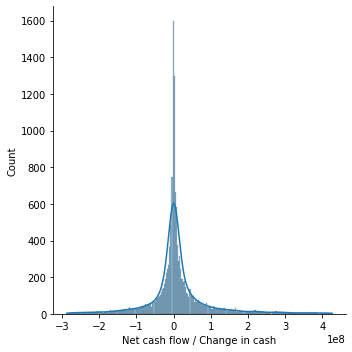

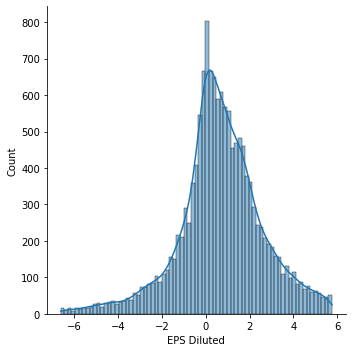

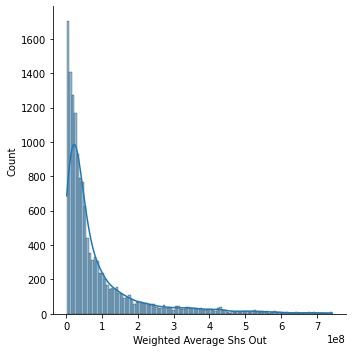

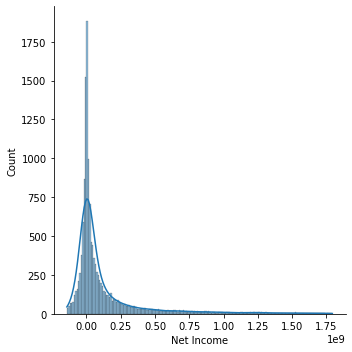

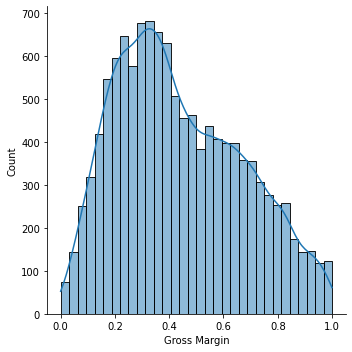

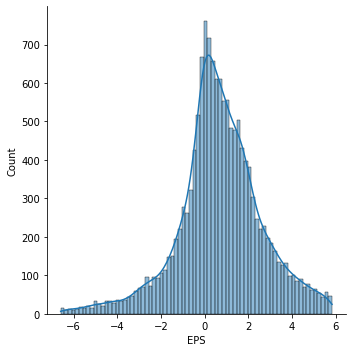

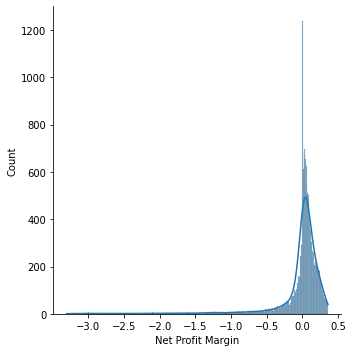

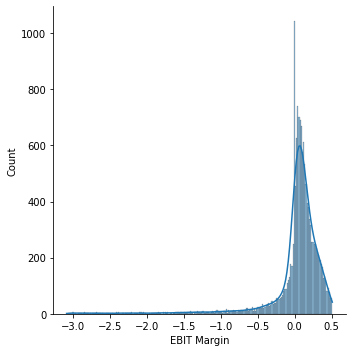

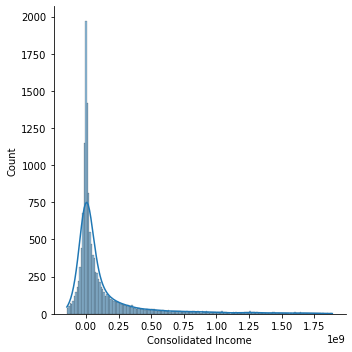

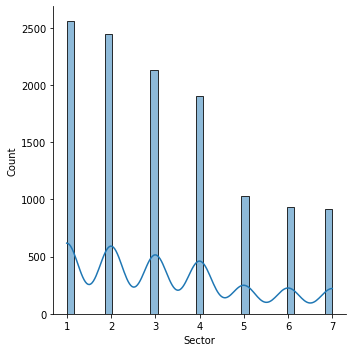

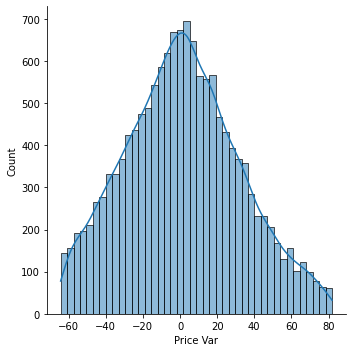

In [ ]:
# revisemos las distribuciones de los datos.
delta = 0.05
for k in all_columns[:-1]:
    df = all_data[k]
    q_low = df.quantile(delta)
    q_hi  = df.quantile(1-delta)
    sns.displot(df[(df < q_hi) & (df > q_low)], kde=True)


(12184, 12)


C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Pyt

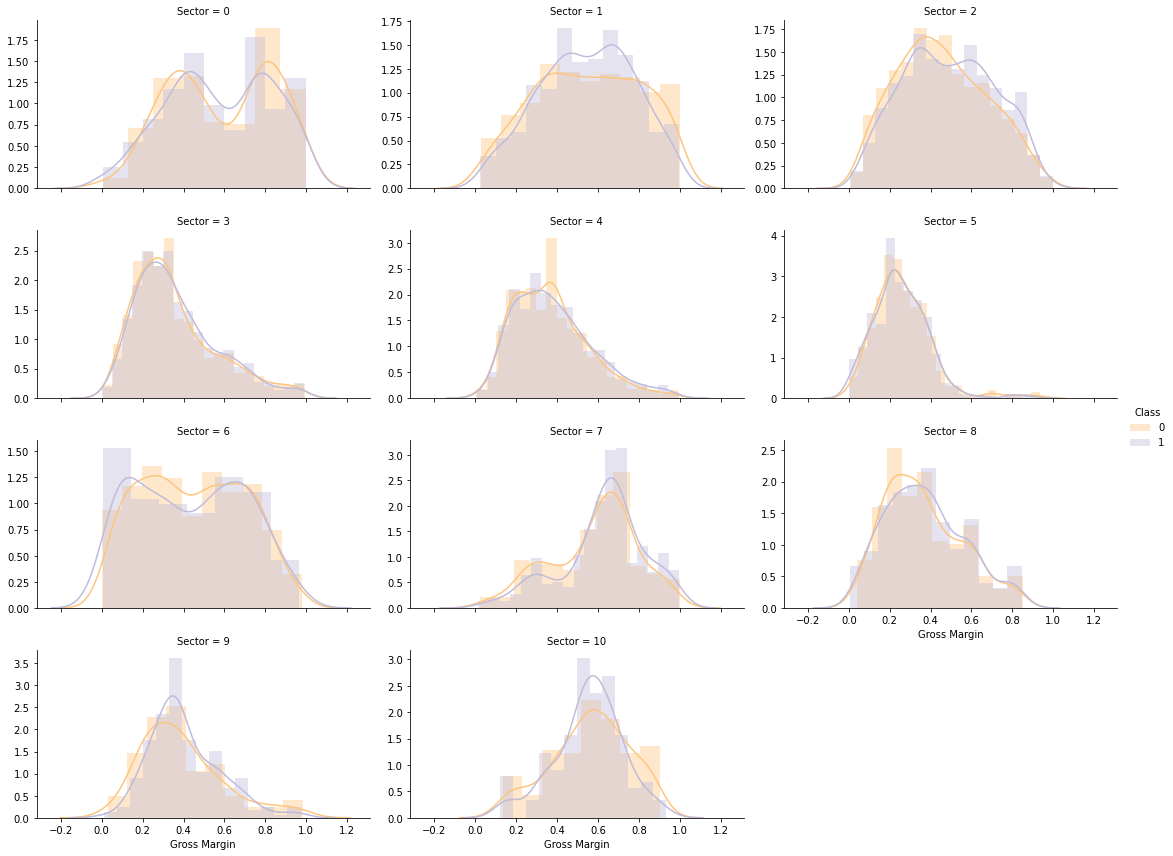

In [ ]:
# revisemos si hay alguna diferenciacion de la distribucion de los datos segun la clase en alguna variable.
column = 'Gross Margin'
delta = 0.05

q_low = all_data[column].quantile(delta)
q_hi  = all_data[column].quantile(1-delta)
dd = all_data[(all_data[column] < q_hi) & (all_data[column] > q_low)]
print(dd.shape)
g = sns.FacetGrid(data=dd, col='Sector', hue='Class', col_wrap=3, sharey=False, aspect=1.75, size=3, palette='PuOr')
g.map(sns.distplot, column)
g.add_legend()

(14372, 12)


C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Pyt

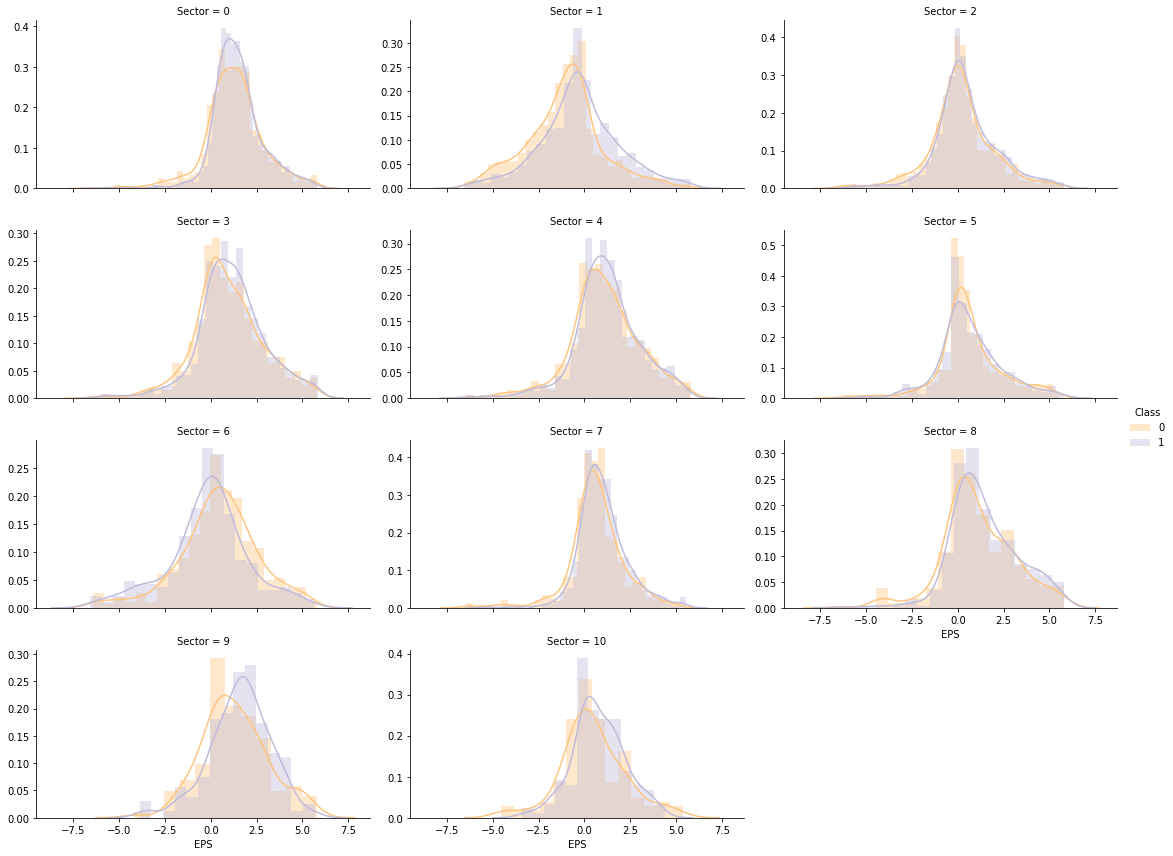

In [ ]:
column = 'EPS'
delta = 0.05

q_low = all_data[column].quantile(delta)
q_hi  = all_data[column].quantile(1-delta)
dd = all_data[(all_data[column] < q_hi) & (all_data[column] > q_low)]
print(dd.shape)
g = sns.FacetGrid(data=dd, col='Sector', hue='Class', col_wrap=3, sharey=False, aspect=1.75, size=3, palette='PuOr')
g.map(sns.distplot, column)
g.add_legend()

(12775, 12)


C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Pyt

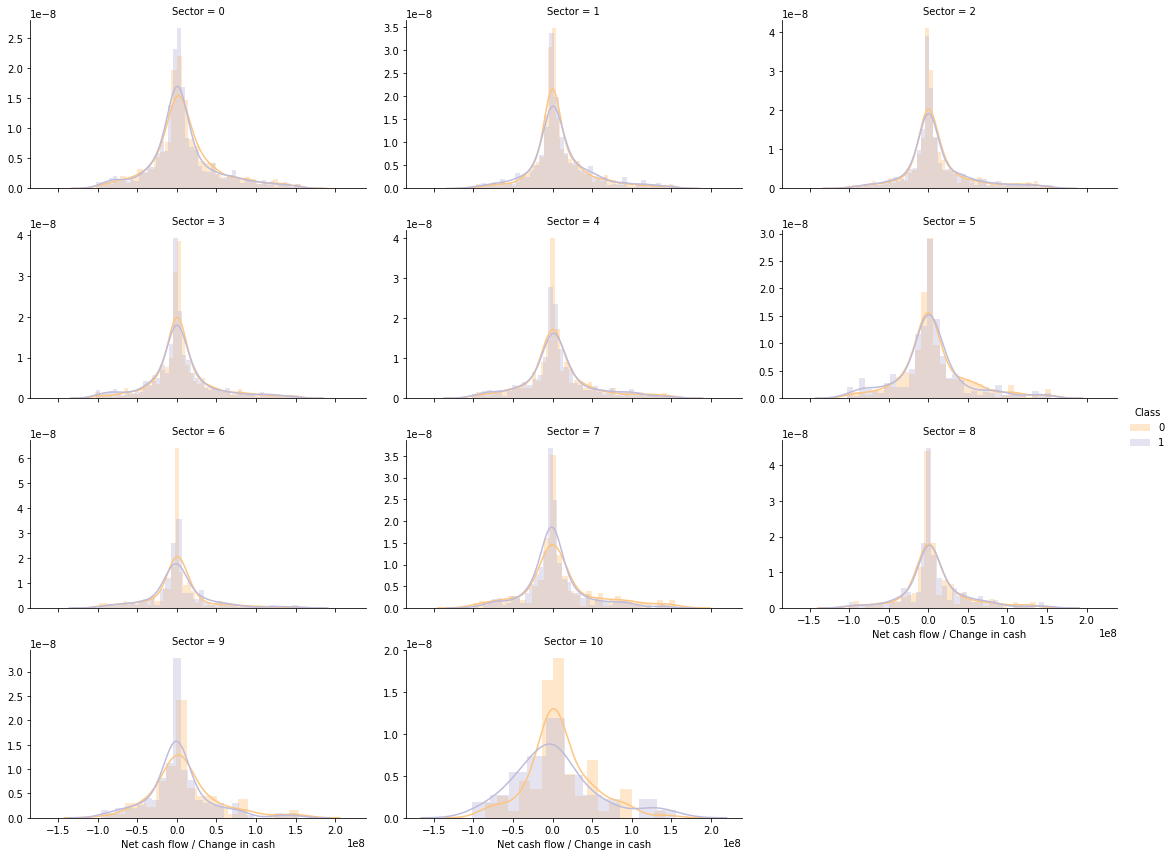

In [ ]:
column = 'Net cash flow / Change in cash'
delta = 0.1

q_low = all_data[column].quantile(delta)
q_hi  = all_data[column].quantile(1-delta)
dd = all_data[(all_data[column] < q_hi) & (all_data[column] > q_low)]
print(dd.shape)
g = sns.FacetGrid(data=dd, col='Sector', hue='Class', col_wrap=3, sharey=False, aspect=1.75, size=3, palette='PuOr')
g.map(sns.distplot, column)
g.add_legend()

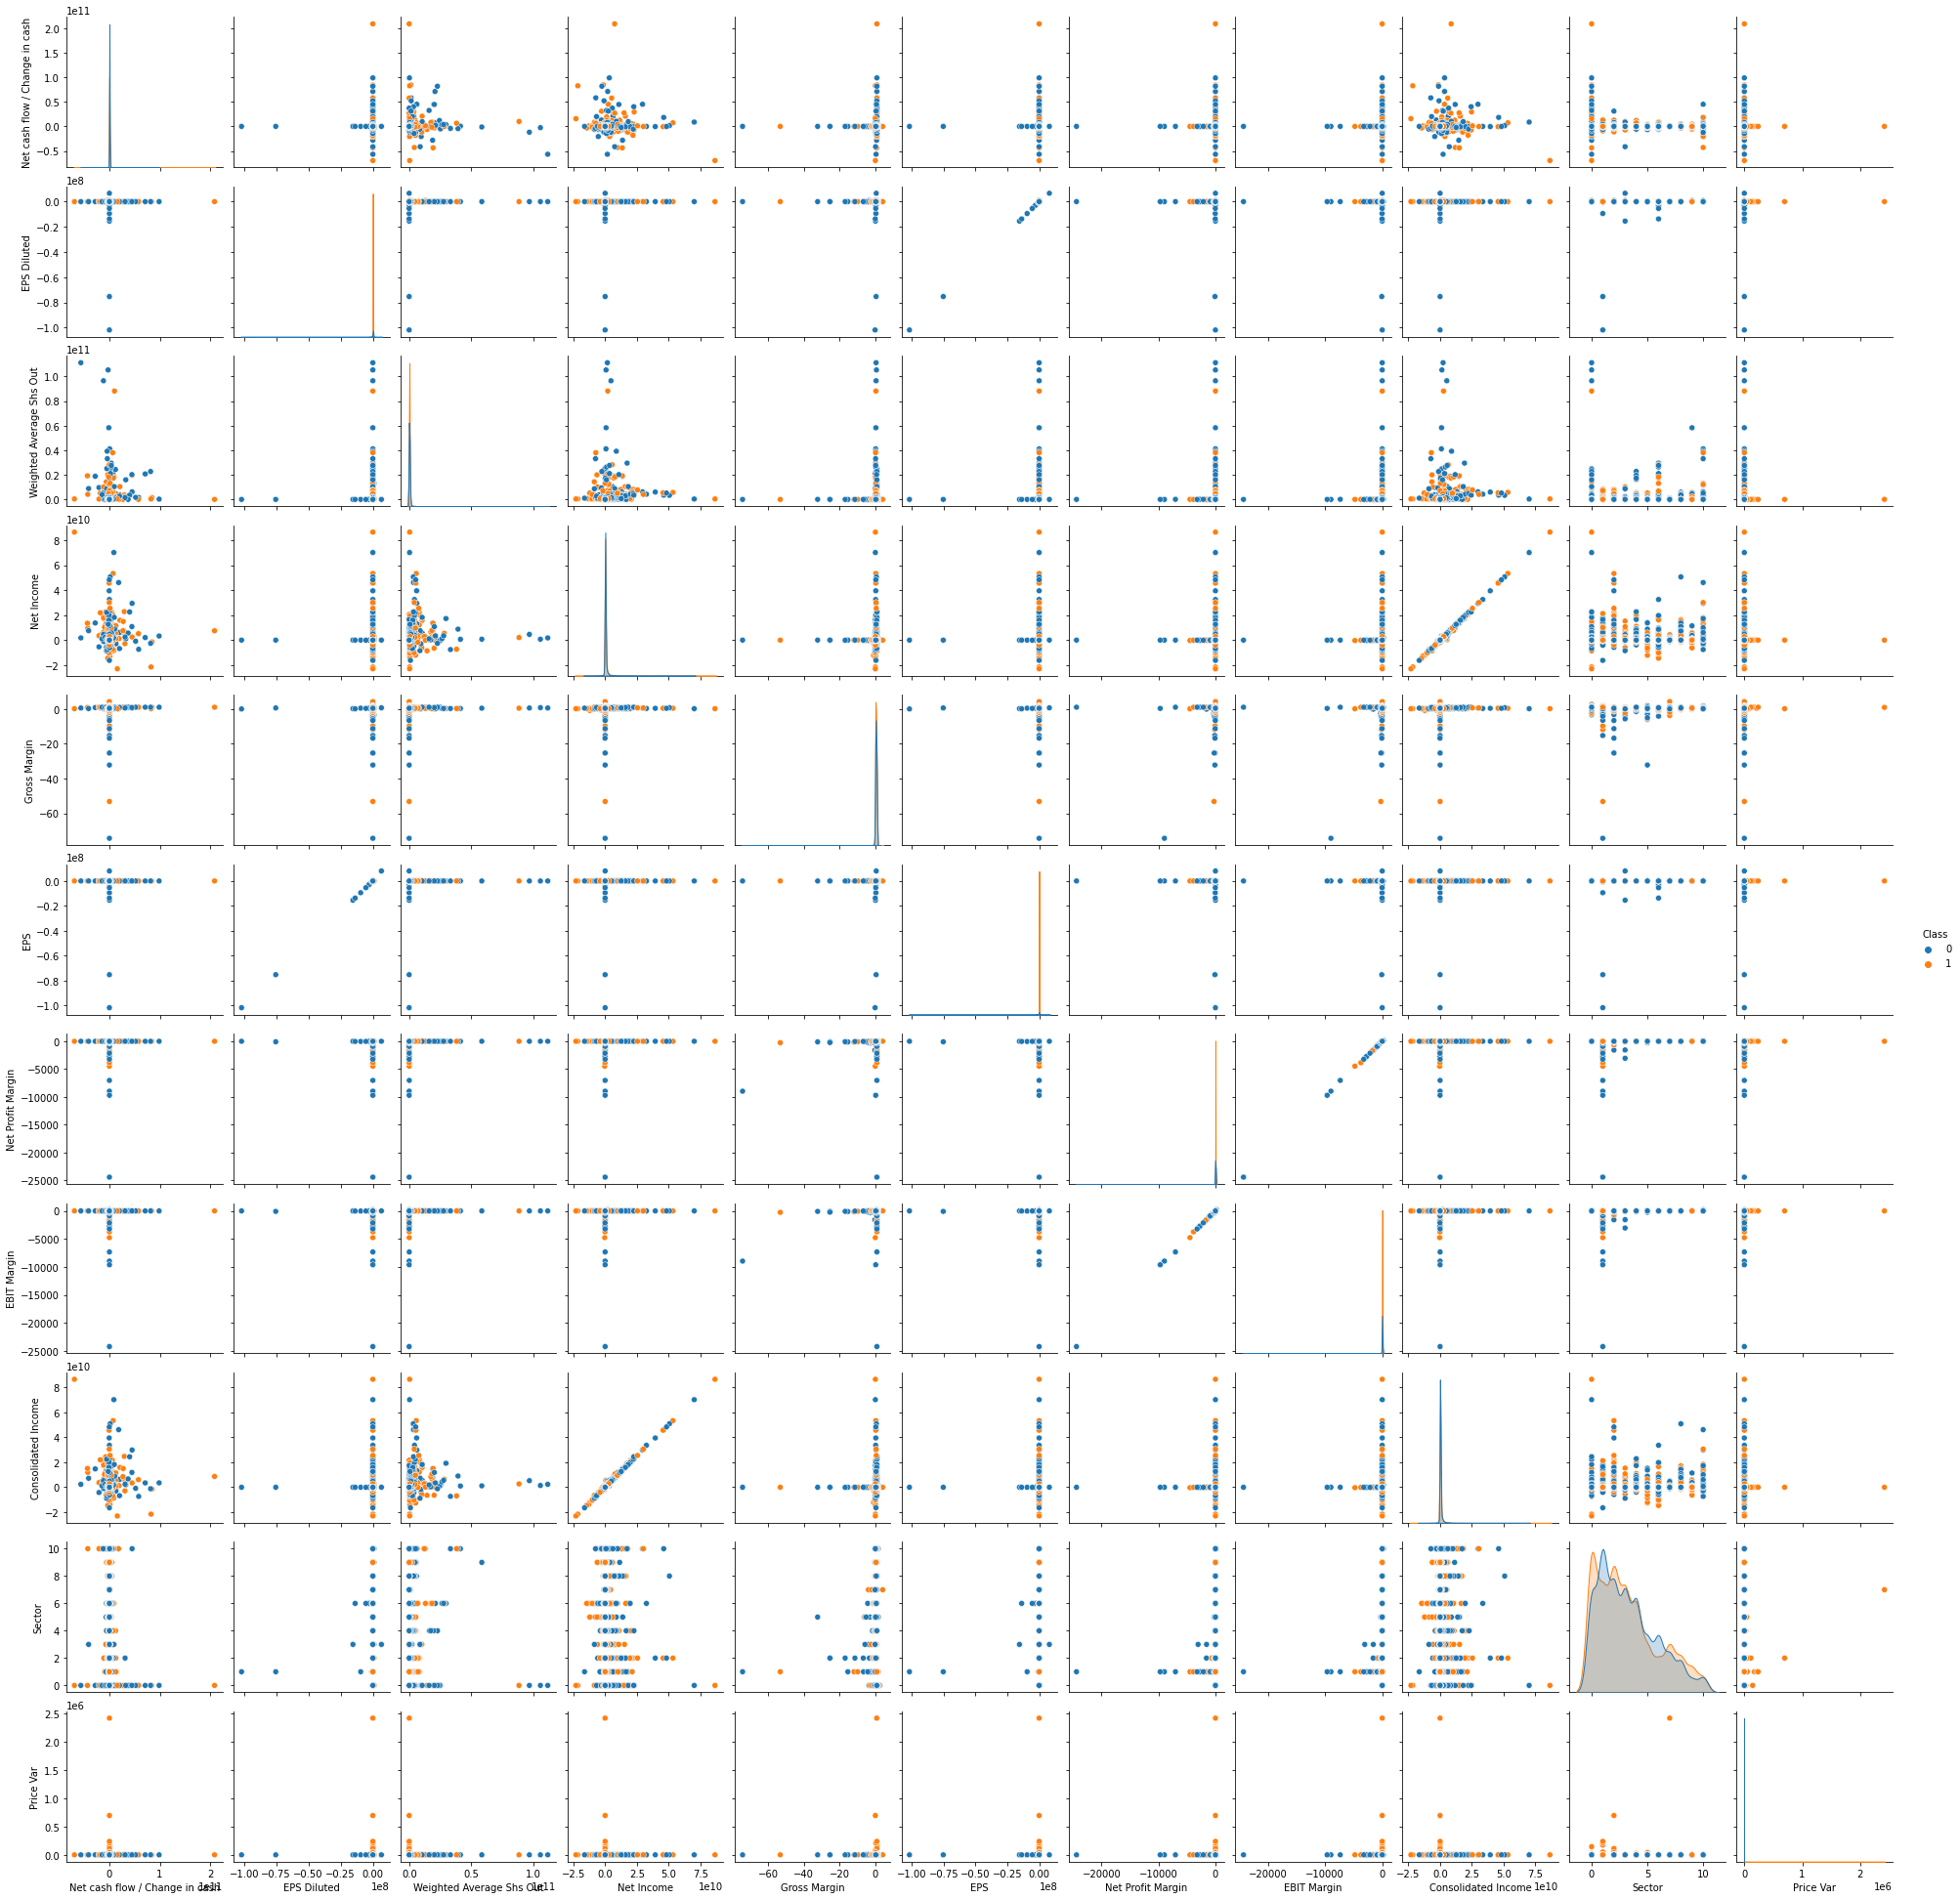

In [ ]:
# revisemos si existen datos correlacionados que no nos aportan informacion extra.
if not debug:
    sns.pairplot(all_data, hue='Class')
else:
    print("image")

In [ ]:
pca = decomposition.PCA(n_components=2)
projected = pca.fit_transform(all_data[data_columns])

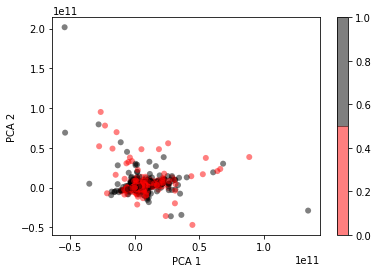

In [ ]:
# Revisemos si hay alguna tendencia o separacion con PCA
plt.scatter(projected[:, 0], projected[:, 1], c=all_data['Class'], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('flag', 2))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()

In [ ]:
if not debug:
    TSNE = manifold.TSNE(n_components=2)
    projected = TSNE.fit_transform(all_data[data_columns])

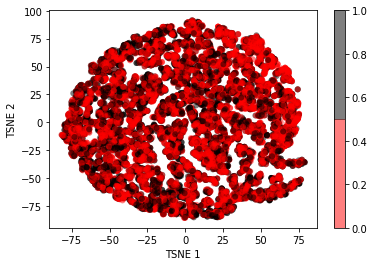

In [ ]:
# Revisemos si hay alguna tendencia o separacion con TSNE
if not debug:
    plt.scatter(projected[:, 0], projected[:, 1], c=all_data['Class'], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('flag', 2))
    plt.xlabel('TSNE 1')
    plt.ylabel('TSNE 2')
    plt.colorbar()

# M4

In [ ]:
all_data.head(), all_data.shape

(   Net cash flow / Change in cash  EPS Diluted  Weighted Average Shs Out  \
 0                    2.618000e+09        4.010              2.705960e+09   
 1                    4.463169e+08        0.226              8.570109e+05   
 2                    1.630000e+08        1.450              1.033053e+09   
 3                    1.695400e+07        4.600              4.832628e+07   
 4                    1.259000e+08        2.830              6.144922e+08   
 
      Net Income  Gross Margin     EPS  Net Profit Margin  EBIT Margin  \
 0  1.164300e+10        0.4754  4.1900             0.1565       0.2043   
 1  1.358227e+08        0.2487  0.2396             0.0364       0.0502   
 2  1.519000e+09        0.2057  1.4700             0.0154       0.0276   
 3  2.494140e+08        0.2869  4.6000             0.0098       0.0264   
 4  1.824400e+09        0.3557  2.9000             0.1019       0.1681   
 
    Consolidated Income  Sector  Price Var  Class  
 0         1.178500e+10       8  -9.32

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [ ]:
# vamos a eliminar 'consolidated income', 'Ebit Margin', 'EPS Diluted' ya que hay una correlacion muy fuerte con otros features
# y no nos aportarioa a mejorar la prediccion. 
data_columns = ['Net cash flow / Change in cash', 'Weighted Average Shs Out', 'Net Income', 'Gross Margin', 'EPS', 'Net Profit Margin', 'Sector']

l_price = all_data['Price Var']
l_class = all_data['Class']
ts = all_data[data_columns]

ts.head()

Net cash flow / Change in cash  Weighted Average Shs Out    Net Income  \
0                    2.618000e+09              2.705960e+09  1.164300e+10   
1                    4.463169e+08              8.570109e+05  1.358227e+08   
2                    1.630000e+08              1.033053e+09  1.519000e+09   
3                    1.695400e+07              4.832628e+07  2.494140e+08   
4                    1.259000e+08              6.144922e+08  1.824400e+09   

   Gross Margin     EPS  Net Profit Margin  Sector  
0        0.4754  4.1900             0.1565       8  
1        0.2487  0.2396             0.0364       8  
2        0.2057  1.4700             0.0154       8  
3        0.2869  4.6000             0.0098       8  
4        0.3557  2.9000             0.1019       8

In [ ]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(ts, l_class, test_size=0.2)

Accuracy: 0.5602290954875512
Confusion matrix:


<AxesSubplot:>

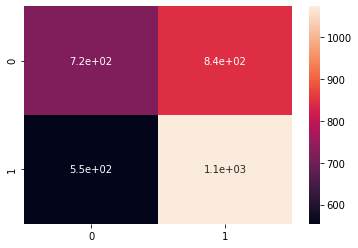

In [ ]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)
predicted = tree.predict(X_test)
print("Accuracy: %s" % metrics.balanced_accuracy_score(y_test, predicted))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(y_test, predicted), annot=True)

In [ ]:
model = DecisionTreeClassifier()

param_grid = {'max_depth': [x for x in range(3,16, 3)],
              'criterion': ['gini', 'entropy']}

# run grid search
scorer = metrics.make_scorer(metrics.r2_score, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs=6, verbose=10)
grid_search.fit(X_train, y_train)
report(grid_search.cv_results_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    1.1s finished


Model with rank: 1
Mean validation score: -0.760 (std: 0.010)
Parameters: {'criterion': 'gini', 'max_depth': 6}

Model with rank: 2
Mean validation score: -0.767 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 6}

Model with rank: 3
Mean validation score: -0.773 (std: 0.031)
Parameters: {'criterion': 'entropy', 'max_depth': 9}



Accuracy: 0.547297689288755
Confusion matrix:


<AxesSubplot:>

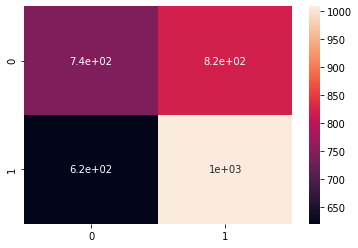

In [ ]:
tree = DecisionTreeClassifier(max_depth=6, criterion='gini')
tree.fit(X_train, y_train)
predicted = tree.predict(X_test)
print("Accuracy: %s" % metrics.balanced_accuracy_score(y_test, predicted))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(y_test, predicted), annot=True)

Accuracy: 0.5008294539245401
Confusion matrix:


<AxesSubplot:>

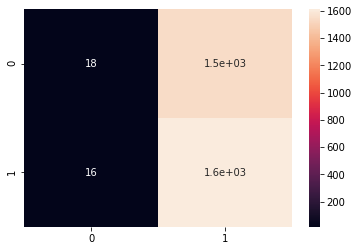

In [ ]:
svc = svm.SVC()
svc.fit(X_train, y_train)
predicted = svc.predict(X_test)
print("Accuracy: %s" % metrics.balanced_accuracy_score(y_test, predicted))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(y_test, predicted), annot=True)

In [ ]:
model = svm.SVC()

param_grid = {'C': [0.6, 0.8, 1.2, 1.4],
              'kernel': ['sigmoid', 'rbf']}

# run grid search
scorer = metrics.make_scorer(metrics.r2_score, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs=6, verbose=10)
grid_search.fit(X_train, y_train)
report(grid_search.cv_results_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done   7 out of  16 | elapsed:    2.7s remaining:    3.5s
[Parallel(n_jobs=6)]: Done   9 out of  16 | elapsed:    3.0s remaining:    2.3s
[Parallel(n_jobs=6)]: Done  11 out of  16 | elapsed:    3.5s remaining:    1.5s
[Parallel(n_jobs=6)]: Done  13 out of  16 | elapsed:    3.9s remaining:    0.8s
[Parallel(n_jobs=6)]: Done  16 out of  16 | elapsed:    4.9s finished


Model with rank: 1
Mean validation score: -0.961 (std: 0.006)
Parameters: {'C': 1.2, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: -0.963 (std: 0.006)
Parameters: {'C': 1.4, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: -0.963 (std: 0.003)
Parameters: {'C': 0.8, 'kernel': 'rbf'}



Accuracy: 0.5017986528037581
Confusion matrix:


<AxesSubplot:>

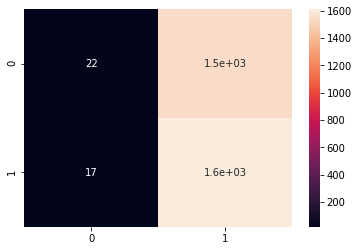

In [ ]:
svc = svm.SVC(C=1.2, kernel='rbf')
svc.fit(X_train, y_train)
predicted = svc.predict(X_test)
print("Accuracy: %s" % metrics.balanced_accuracy_score(y_test, predicted))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(y_test, predicted), annot=True)

Accuracy: 0.503666688095533
Confusion matrix:


<AxesSubplot:>

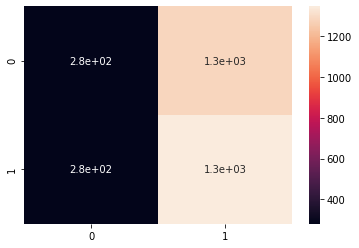

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50,50,50), max_iter=1000)
mlp.fit(X_train, y_train)
predicted = mlp.predict(X_test)

#Medidas de rendimiento
print("Accuracy: %s" % metrics.balanced_accuracy_score(y_test, predicted))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(y_test, predicted), annot=True)

In [ ]:
model = MLPClassifier(max_iter=1000)

param_grid = {'hidden_layer_sizes': [tuple([x*10 for _ in range(x+1)]) for x in [2,4,6,8]],
             'alpha': 10.0 ** -np.arange(1, 5),
             'learning_rate_init': [0.1, 0.01, 0.001],
             'learning_rate': ['invscaling', 'adaptive'],
             'activation': ['relu', 'identity', 'tanh']}


scorer = metrics.make_scorer(metrics.r2_score, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs=6, verbose=10)
grid_search.fit(X_train, y_train)
report(grid_search.cv_results_)

Fitting 2 folds for each of 288 candidates, totalling 576 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    5.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    9.6s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   30.1s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   39.4s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   45.3s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   59.6s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  2.3min
[Parallel(

Model with rank: 1
Mean validation score: -0.734 (std: 0.030)
Parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (40, 40, 40, 40, 40), 'learning_rate': 'invscaling', 'learning_rate_init': 0.1}

Model with rank: 2
Mean validation score: -0.743 (std: 0.026)
Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (40, 40, 40, 40, 40), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001}

Model with rank: 3
Mean validation score: -0.746 (std: 0.005)
Parameters: {'activation': 'identity', 'alpha': 0.1, 'hidden_layer_sizes': (60, 60, 60, 60, 60, 60, 60), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1}



Accuracy: 0.5
Confusion matrix:


<AxesSubplot:>

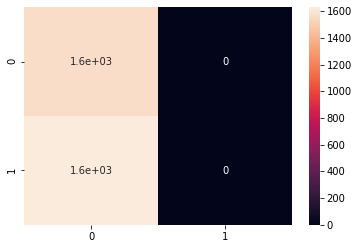

In [ ]:
params = {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (40, 40, 40, 40, 40), 'learning_rate': 'invscaling', 'learning_rate_init': 0.1}
mlp = MLPClassifier(**params)
mlp.fit(X_train, y_train)
predicted = mlp.predict(X_test)

#Medidas de rendimiento
print("Accuracy: %s" % metrics.balanced_accuracy_score(y_test, predicted))
print("Confusion matrix:")
sns.heatmap(metrics.confusion_matrix(y_test, predicted), annot=True)

Podemos ver que en general no existe una correlación clara entre los indicadores y la calidad de la acción. Curiosamente árboles de decisión funcionaron mejor que el resto aunque probablemente tuvimos suerte, ya que todos tienen un score muy similar en la validación cruzada y con una desviación bastante alta. Sin embargo, esto nos indica que es un modelo bastante decente y mucho mas rápido de computar que el resto. SVM's no tuvieron tan buen rendimiento, esto se veía venir ya que con TSNE y PCA no pudimos diferenciar ningún tipo de separación entre las diferentes clases. Finalmente, MLP a pesar de su gran poder de representación no fue mucho mejor (solo respondio que no). Ademas, tiene una gran desventaja que es el tiempo de entrenamiento y la cantidad de hiperparametros con los que se puede "jugar".


# M5

Como ya partimos eligiendo columnas de acuerdo a unos cirterios bastante razonables, sigamos buscando para reemplazar las columnas que encontramos que estaban muy correlacionadas con las demas. 

In [ ]:
# tras una pequenha busqueda por google, estos deberian ser buenos indicadores. Revisemos como se comportan con los que ya tenemos.
new_columns = ['priceToFreeCashFlowsRatio', 'Net Cash/Marketcap', 'Gross Profit Growth', 'pretaxProfitMargin', 'priceSalesRatio', 'returnOnAssets', 'ROIC', 'returnOnEquity', 'Intangibles to Total Assets', 'Goodwill and Intangible Assets']
data_columns = ['Net cash flow / Change in cash', 'Weighted Average Shs Out', 'Net Income', 'Gross Margin', 'EPS', 'Net Profit Margin', 'Sector']
all_columns = new_columns + data_columns
all_columns

['priceToFreeCashFlowsRatio',
 'Net Cash/Marketcap',
 'Gross Profit Growth',
 'pretaxProfitMargin',
 'priceSalesRatio',
 'returnOnAssets',
 'ROIC',
 'returnOnEquity',
 'Intangibles to Total Assets',
 'Goodwill and Intangible Assets',
 'Net cash flow / Change in cash',
 'Weighted Average Shs Out',
 'Net Income',
 'Gross Margin',
 'EPS',
 'Net Profit Margin',
 'Sector']

In [ ]:
sector_transform = {'Financial Services' : 0,
'Healthcare' : 1,
'Technology' : 2,
'Industrials' : 3,
'Consumer Cyclical' : 4,
'Basic Materials' : 5,
'Energy' : 6,
'Real Estate' : 7,
'Consumer Defensive' : 8,
'Utilities' : 9,
'Communication Services' : 10}
data = {}
for i in range(2014, 2019):
    print(i)
    data[i] = pd.read_csv(f'{i}_Financial_data.csv')
    
data_pruned = dict()
for k in data:
    data_pruned[k] = data[k][all_columns + [f'{k+1} PRICE VAR [%]']]
    data_pruned[k].columns = all_columns + ['PriceVar']
    data_pruned[k]['Sector'] = data_pruned[k]['Sector'].apply(lambda x: sector_transform[x])
columns = all_columns + ['PriceVar']
data_pruned[2015].head()

2014
2015
2016
2017
2018


<ipython-input-46-1e2fff7bbe56>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pruned[k]['Sector'] = data_pruned[k]['Sector'].apply(lambda x: sector_transform[x])


priceToFreeCashFlowsRatio  Net Cash/Marketcap  Gross Profit Growth  \
0                    19.5240             -0.0883              -0.0474   
1                     0.0000              0.0956               0.6420   
2                    24.6951             -0.3309               0.1342   
3                    36.0675             -0.6794               0.0345   
4                    18.2220             -0.2640              -0.0660   

   pretaxProfitMargin  priceSalesRatio  returnOnAssets    ROIC  \
0            0.156172         2.635163          0.3606  0.0690   
1            0.051502         0.043959          0.5544  0.4691   
2            0.028922         0.293287          0.1120  0.0948   
3            0.031775         0.302005          0.5510  0.0839   
4            0.117826         1.637928          0.4736  0.0762   

   returnOnEquity  Intangibles to Total Assets  \
0          0.1116                       0.5377   
1          0.4492                       0.0524   
2          0.3193                       0.1004   
3         36.9667                       0.0567   
4          0.2444                       0.6207   

   Goodwill and Intangible Assets  Net cash flow / Change in cash  \
0                    6.963200e+10                   -1.712000e+09   
1                    1.618567e+08                   -2.259077e+08   
2                    3.061000e+09                   -1.330000e+08   
3                    4.976040e+08                   -3.050700e+07   
4                    1.355190e+10                   -5.331000e+08   

   Weighted Average Shs Out    Net Income  Gross Margin      EPS  \
0              2.712996e+09  7.036000e+09        0.4762   2.5000   
1              1.796270e+07  2.449029e+08        0.2462   0.4234   
2              9.826488e+08  1.728000e+09        0.2116   1.7400   
3              4.909133e+07  2.109173e+09        0.2856  43.4000   
4              5.960900e+08  1.221300e+09        0.3374   2.0200   

   Net Profit Margin  Sector   PriceVar  
0             0.0995       8  10.809451  
1             0.0395       8 -21.637010  
2             0.0159       8 -15.036503  
3             0.0795       8   4.303799  
4             0.0693       8  10.693172

0 priceToFreeCashFlowsRatio
count    15661.000000
mean        39.225845
std        720.373345
min          0.000000
25%          0.000000
50%          9.221200
75%         20.667500
max      60328.774100
Name: priceToFreeCashFlowsRatio, dtype: float64

normalized std: 18.36476272510999
percentile skewness: 3.4025831778944173
outliers: 1160
Total Data in 4 years: 15661
Percentage of outliers: 7%


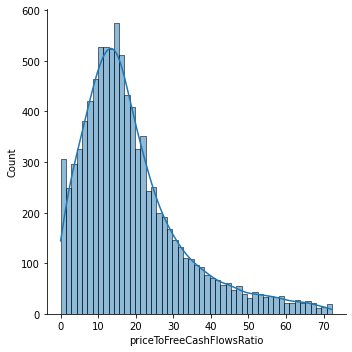



1 Net Cash/Marketcap
count    14827.000000
mean        -1.056060
std         48.278743
min      -4943.552900
25%         -0.415500
50%         -0.059900
75%          0.107650
max        434.744500
Name: Net Cash/Marketcap, dtype: float64

normalized std: 45.715891114322424
percentile skewness: 0.37546315356113624
outliers: 1578
Total Data in 4 years: 14827
Percentage of outliers: 11%


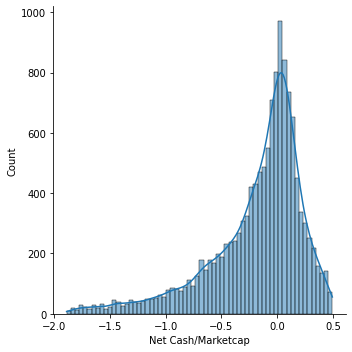



2 Gross Profit Growth
count     15802.000000
mean         23.505890
std        2680.503323
min        -224.482800
25%          -0.027400
50%           0.060000
75%           0.211175
max      336767.800000
Name: Gross Profit Growth, dtype: float64

normalized std: 114.03538776921404
percentile skewness: 1.9236789925905313
outliers: 2667
Total Data in 4 years: 15802
Percentage of outliers: 17%


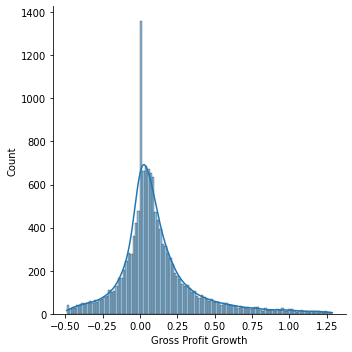



3 pretaxProfitMargin
count    15170.000000
mean        -8.654038
std        247.601061
min     -24577.000000
25%         -0.010757
50%          0.087992
75%          0.214860
max        198.684211
Name: pretaxProfitMargin, dtype: float64

normalized std: 28.6110422932903
percentile skewness: 0.39256113679118443
outliers: 2575
Total Data in 4 years: 15170
Percentage of outliers: 17%


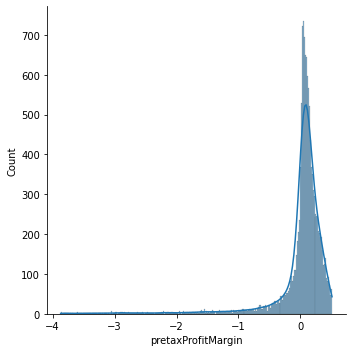



4 priceSalesRatio
count     14780.000000
mean         92.779371
std        3855.088053
min           0.000000
25%           0.697982
50%           1.751109
75%           3.861995
max      377315.796107
Name: priceSalesRatio, dtype: float64

normalized std: 41.55113393083128
percentile skewness: 4.237172080636147
outliers: 1441
Total Data in 4 years: 14780
Percentage of outliers: 10%


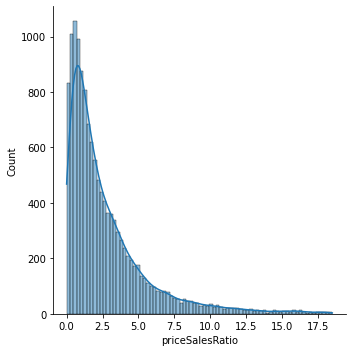



5 returnOnAssets
count    12256.000000
mean        -0.081677
std          8.757195
min       -344.437500
25%         -0.152150
50%          0.043600
75%          0.166400
max        345.631000
Name: returnOnAssets, dtype: float64

normalized std: 107.21698373421452
percentile skewness: 0.428395621478075
outliers: 2113
Total Data in 4 years: 12256
Percentage of outliers: 17%


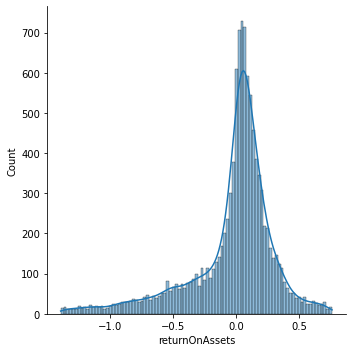



6 ROIC
count    12278.000000
mean        -0.016653
std         39.595081
min       -616.644600
25%         -0.013600
50%          0.035200
75%          0.094100
max       3863.903700
Name: ROIC, dtype: float64

normalized std: 2377.722395586253
percentile skewness: 0.3678696445299021
outliers: 2347
Total Data in 4 years: 12278
Percentage of outliers: 19%


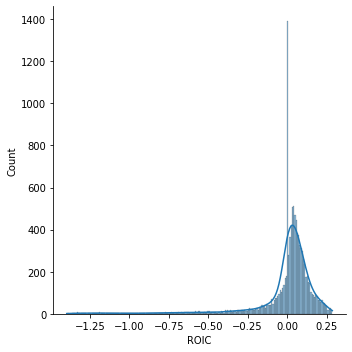



7 returnOnEquity
count    1.560300e+04
mean     1.370486e+03
std      9.340724e+04
min     -9.693878e+02
25%     -6.285000e-02
50%      7.050000e-02
75%      1.444500e-01
max      8.255949e+06
Name: returnOnEquity, dtype: float64

normalized std: 68.15631026224774
percentile skewness: 0.37458093066917025
outliers: 2954
Total Data in 4 years: 15603
Percentage of outliers: 19%


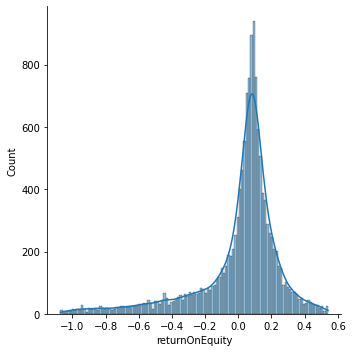



8 Intangibles to Total Assets
count    15734.000000
mean         0.152370
std          0.207806
min          0.000000
25%          0.000000
50%          0.041700
75%          0.245475
max          0.995300
Name: Intangibles to Total Assets, dtype: float64

normalized std: 1.3638201195678283
percentile skewness: 10.70503597122302
outliers: 796
Total Data in 4 years: 15734
Percentage of outliers: 5%


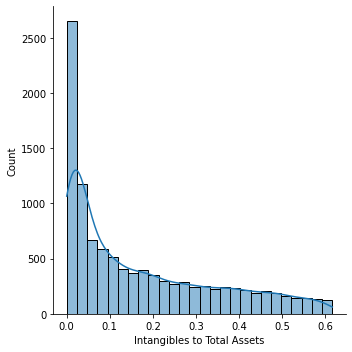



9 Goodwill and Intangible Assets
count    1.639000e+04
mean     1.678888e+09
std      8.565680e+09
min      0.000000e+00
25%      0.000000e+00
50%      3.292800e+07
75%      4.644000e+08
max      3.861800e+11
Name: Goodwill and Intangible Assets, dtype: float64

normalized std: 5.101996350783733
percentile skewness: 85.2116405490768
outliers: 2731
Total Data in 4 years: 16390
Percentage of outliers: 17%


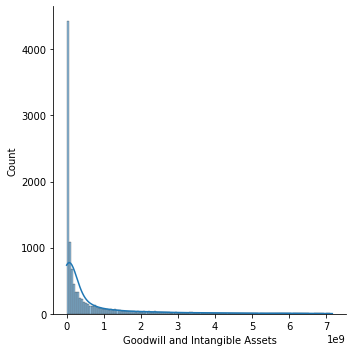



10 Net cash flow / Change in cash
count    1.669100e+04
mean     2.859670e+07
std      2.663943e+10
min     -9.880000e+11
25%     -1.521600e+07
50%      7.960000e+05
75%      2.986950e+07
max      9.880000e+11
Name: Net cash flow / Change in cash, dtype: float64

normalized std: 931.5559286555326
percentile skewness: 1.4767530661981312
outliers: 4222
Total Data in 4 years: 16691
Percentage of outliers: 25%


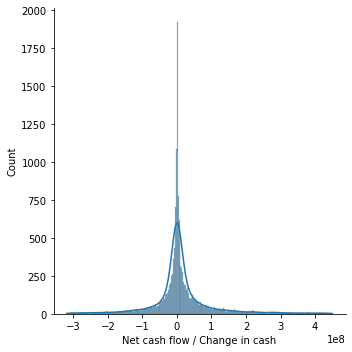



11 Weighted Average Shs Out
count    1.625700e+04
mean     2.621989e+08
std      2.051678e+09
min      0.000000e+00
25%      1.677013e+07
50%      4.300000e+07
75%      1.158548e+08
max      1.112919e+11
Name: Weighted Average Shs Out, dtype: float64

normalized std: 7.82489322387941
percentile skewness: 8.388679540166851
outliers: 2123
Total Data in 4 years: 16257
Percentage of outliers: 13%


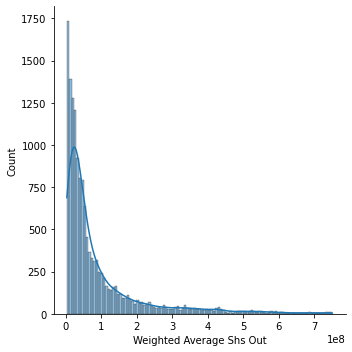



12 Net Income
count    1.627100e+04
mean     3.733851e+08
std      2.764139e+09
min     -2.304500e+10
25%     -8.525000e+06
50%      1.740000e+07
75%      1.489555e+08
max      2.339970e+11
Name: Net Income, dtype: float64

normalized std: 7.402915928762996
percentile skewness: 9.658898103782933
outliers: 2957
Total Data in 4 years: 16271
Percentage of outliers: 18%


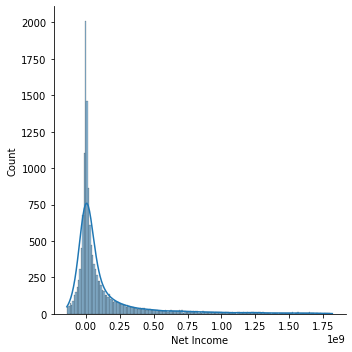



13 Gross Margin
count    16537.000000
mean         0.485343
std          1.019607
min        -74.319100
25%          0.250000
50%          0.459400
75%          0.801700
max         31.000000
Name: Gross Margin, dtype: float64

normalized std: 2.100797568551053
percentile skewness: 1.5179423822092437
outliers: 99
Total Data in 4 years: 16537
Percentage of outliers: 1%


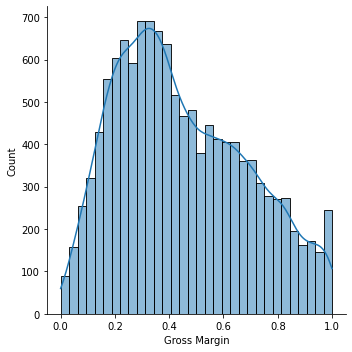



14 EPS
count    1.644900e+04
mean    -1.344259e+04
std      1.007070e+06
min     -1.018709e+08
25%     -3.900000e-01
50%      6.300000e-01
75%      1.950000e+00
max      8.028004e+06
Name: EPS, dtype: float64

normalized std: 74.9163340770086
percentile skewness: 1.0476398713826374
outliers: 2078
Total Data in 4 years: 16449
Percentage of outliers: 13%


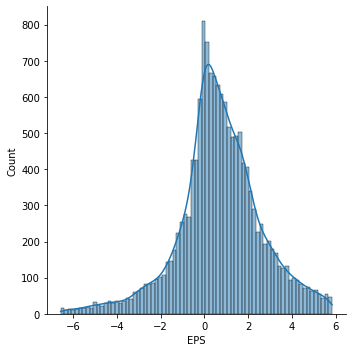



15 Net Profit Margin
count    16139.000000
mean        -7.923216
std        239.380809
min     -24414.000000
25%         -0.025900
50%          0.043600
75%          0.134136
max        156.461538
Name: Net Profit Margin, dtype: float64

normalized std: 30.21258114843243
percentile skewness: 0.341961679989849
outliers: 2944
Total Data in 4 years: 16139
Percentage of outliers: 18%


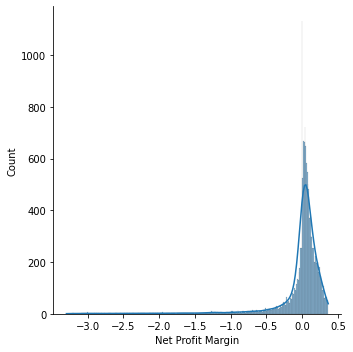



16 Sector
count    17685.000000
mean         3.010687
std          2.705446
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         10.000000
Name: Sector, dtype: float64

outliers: 0
Total Data in 4 years: 17685
Percentage of outliers: 0%


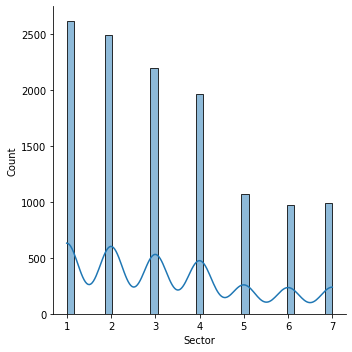



17 PriceVar
count    1.768500e+04
mean     3.317486e+02
std      2.161500e+04
min     -1.003972e+02
25%     -2.154010e+01
50%      1.085100e+00
75%      2.346524e+01
max      2.418601e+06
Name: PriceVar, dtype: float64

normalized std: 65.15476220246025
percentile skewness: 1.0704979062308333
outliers: 1042
Total Data in 4 years: 17685
Percentage of outliers: 6%


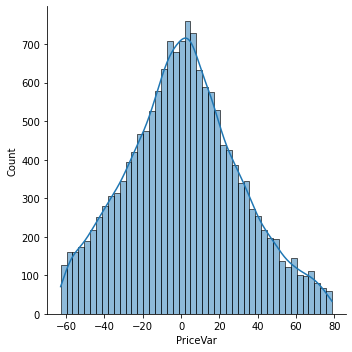

In [ ]:
outliers = defaultdict(int)
cant = defaultdict(int)

delta = 0.05

for y in range(2014, 2018):
    for k in columns:
        
        d = data_pruned[y][k]
        cant[k] += int(d.describe()['count'])
        if k == 'Sector':
            outliers[k] = 0
            continue
        Q1 = d.quantile(0.25)
        Q3 = d.quantile(0.75)
        R = Q3 - Q1
        outliers[k] += ((d < (Q1 - 1.5*R)) | (d > (Q3 + 1.5*R))).sum()
        
for i, k in enumerate(columns):
    print(i, k)
    df = pd.concat([data_pruned[2014][k], data_pruned[2015][k], data_pruned[2016][k], data_pruned[2017][k]])
    info = df.describe()
    print(info)
    print()

    if k != 'Sector': # sector al ser cualitativo no tiene std, mena ni cuantiles.
        print(f'normalized std: {info["std"] / abs(info["mean"])}')
        print(f'percentile skewness: {(df.quantile(.9)-df.quantile(.5))/(df.quantile(.5) - df.quantile(.1))}')
    print(f'outliers: {outliers[k]}')
    print(f'Total Data in 4 years: {cant[k]}')
    print(f'Percentage of outliers: {round(outliers[k]/cant[k]*100)}%')
    

    q_low = df.quantile(delta)
    q_hi  = df.quantile(1-delta)
    sns.displot(df[(df < q_hi) & (df > q_low)], kde=True)
    plt.show()

    print()
    print()

In [ ]:
all_data = pd.concat([data_pruned[2014], data_pruned[2015], data_pruned[2016], data_pruned[2017]])
all_data.head()

priceToFreeCashFlowsRatio  Net Cash/Marketcap  Gross Profit Growth  \
0                    21.0348             -0.1163              -0.1185   
1                     1.3589              0.0956               1.2489   
2                    14.6302             -0.5969               0.0173   
3                    17.2736             -0.8822               0.0007   
4                    17.6902             -0.2376              -0.0084   

   pretaxProfitMargin  priceSalesRatio  returnOnAssets    ROIC  \
0            0.186960         2.434644          0.5765  0.0753   
1            0.036045         0.095727          0.0403  0.0000   
2            0.027700         0.000000          0.1011  0.0859   
3            0.028882         0.000000          0.0668  0.1062   
4            0.165129         1.553911          0.6265  0.1041   

   returnOnEquity  Intangibles to Total Assets  \
0          0.1664                       0.5860   
1          0.3294                       0.0697   
2          0.2821                       0.0969   
3         -0.1180                       0.0621   
4          0.2792                       0.5904   

   Goodwill and Intangible Assets  Net cash flow / Change in cash  \
0                    8.454700e+10                    2.618000e+09   
1                    1.906587e+08                    4.463169e+08   
2                    2.837000e+09                    1.630000e+08   
3                    4.312270e+08                    1.695400e+07   
4                    1.366480e+10                    1.259000e+08   

   Weighted Average Shs Out    Net Income  Gross Margin     EPS  \
0              2.705960e+09  1.164300e+10        0.4754  4.1900   
1                       NaN  1.358227e+08        0.2487  0.2396   
2              1.033053e+09  1.519000e+09        0.2057  1.4700   
3              4.832628e+07  2.494140e+08        0.2869  4.6000   
4              6.144922e+08  1.824400e+09        0.3557  2.9000   

   Net Profit Margin  Sector   PriceVar  
0             0.1565       8  -9.323276  
1             0.0364       8 -25.512193  
2             0.0154       8  33.118297  
3             0.0098       8   2.752291  
4             0.1019       8  12.897715

In [ ]:
plot_data = all_data.sample(700)
plot_data['PriceVar'] = plot_data['PriceVar'].apply(lambda x: round(x, -1))
plot_data.head()

priceToFreeCashFlowsRatio  Net Cash/Marketcap  Gross Profit Growth  \
141                     36.1235              0.4783               0.1257   
3681                    17.6388             -0.1135               0.0723   
844                      0.0000              0.0380               0.0000   
3620                     0.0000             -0.1164               0.4445   
3293                        NaN                 NaN                  NaN   

      pretaxProfitMargin  priceSalesRatio  returnOnAssets    ROIC  \
141             0.052309         0.481173          0.0794  0.0993   
3681            0.067412         3.055925          0.4542  0.0514   
844                  NaN              NaN         92.5218  0.0000   
3620            0.023994         3.498428          0.1225  0.0100   
3293                 NaN              NaN             NaN     NaN   

      returnOnEquity  Intangibles to Total Assets  \
141           0.0763                       0.0000   
3681          0.0914                       0.6951   
844         -22.3085                       0.2356   
3620          0.1145                       0.3915   
3293             NaN                          NaN   

      Goodwill and Intangible Assets  Net cash flow / Change in cash  \
141                     0.000000e+00                       -961000.0   
3681                    2.608869e+09                     -32000000.0   
844                     8.087260e+05                       1250260.0   
3620                    3.370120e+08                     -51583000.0   
3293                             NaN                             NaN   

      Weighted Average Shs Out   Net Income  Gross Margin   EPS  \
141                  6839974.0    3346000.0        0.1803  0.50   
3681               250481619.0  214100000.0        0.5249  0.47   
844                 14450717.0   -8213529.0        0.0000 -0.61   
3620                52949032.0   48589000.0        0.4840  0.95   
3293                       NaN          NaN           NaN   NaN   

      Net Profit Margin  Sector  PriceVar  
141              0.0421       8      10.0  
3681             0.0894       2      40.0  
844              0.0000       1      10.0  
3620             0.1155       2      20.0  
3293                NaN       0       0.0

In [ ]:
if not debug:
    plot = sns.pairplot(plot_data, hue='PriceVar', palette=sns.color_palette("flare", len((plot_data['PriceVar'].value_counts()))), size=10.0)
    plot.savefig("pairplot.png")
    plt.clf() # Clean parirplot figure from sns 
Image(filename='pairplot.png') # Show pairplot as image

C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roami

C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\si

C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Jamidd\AppData\Roaming\Python\Python38\si

<Figure size 12310.8x12240 with 0 Axes>

Podemos ver ciertas correlaciones entre Net Profit Margin y preTaxProfitMargin, por lo que nos vamos a quedar solo con una. 

In [ ]:
#Con la informacion que tenemos, vamos a elegir:
final_columns = []
for k in [0,1,2,4,7,11,12,13,14,16]:
    final_columns.append(columns[k])
final_columns

['priceToFreeCashFlowsRatio',
 'Net Cash/Marketcap',
 'Gross Profit Growth',
 'priceSalesRatio',
 'returnOnEquity',
 'Weighted Average Shs Out',
 'Net Income',
 'Gross Margin',
 'EPS',
 'Sector']

Finalmente estos van a ser las caracteristicas que vamos a usar. En general no presentan muchos outlier, tienen una distribucion bastante buena, no tienen demasiados NaN que nos quiten informacion, no hay dos correlacionados entre si y en general la literatura los recomienda para este proposito. 


Ahora revisemos como funcionan.

In [ ]:
all_data[final_columns+['PriceVar']]
all_data = all_data.dropna(thresh=5)
all_data

priceToFreeCashFlowsRatio  Net Cash/Marketcap  Gross Profit Growth  \
0                       21.0348             -0.1163              -0.1185   
1                        1.3589              0.0956               1.2489   
2                       14.6302             -0.5969               0.0173   
3                       17.2736             -0.8822               0.0007   
4                       17.6902             -0.2376              -0.0084   
...                         ...                 ...                  ...   
4955                    19.5477              0.4677               0.0288   
4956                    64.5063              0.2906              -0.0677   
4957                        NaN                 NaN                  NaN   
4958                     0.0000              0.0737              -0.0093   
4959                   102.8588              0.0113               0.4634   

      pretaxProfitMargin  priceSalesRatio  returnOnAssets    ROIC  \
0               0.186960         2.434644          0.5765  0.0753   
1               0.036045         0.095727          0.0403  0.0000   
2               0.027700         0.000000          0.1011  0.0859   
3               0.028882         0.000000          0.0668  0.1062   
4               0.165129         1.553911          0.6265  0.1041   
...                  ...              ...             ...     ...   
4955            0.008989         0.230471          0.0348  0.3540   
4956            0.042666         0.810234          0.2809  0.0000   
4957                 NaN              NaN             NaN     NaN   
4958            0.048659         0.414419          0.1598  0.1438   
4959           -0.067733         1.062563         -0.2720 -0.0530   

      returnOnEquity  Intangibles to Total Assets  \
0             0.1664                       0.5860   
1             0.3294                       0.0697   
2             0.2821                       0.0969   
3            -0.1180                       0.0621   
4             0.2792                       0.5904   
...              ...                          ...   
4955          0.0347                       0.0000   
4956          0.2699                       0.0000   
4957             NaN                          NaN   
4958          0.1308                       0.0000   
4959         -0.1280                       0.3148   

      Goodwill and Intangible Assets  Net cash flow / Change in cash  \
0                       8.454700e+10                    2.618000e+09   
1                       1.906587e+08                    4.463169e+08   
2                       2.837000e+09                    1.630000e+08   
3                       4.312270e+08                    1.695400e+07   
4                       1.366480e+10                    1.259000e+08   
...                              ...                             ...   
4955                    0.000000e+00                    1.209819e+06   
4956                    0.000000e+00                   -4.235000e+06   
4957                    1.200000e+07                   -7.000000e+06   
4958                    0.000000e+00                   -7.994000e+06   
4959                    1.477100e+07                   -6.893000e+06   

      Weighted Average Shs Out    Net Income  Gross Margin     EPS  \
0                 2.705960e+09  1.164300e+10      0.475400  4.1900   
1                          NaN  1.358227e+08      0.248700  0.2396   
2                 1.033053e+09  1.519000e+09      0.205700  1.4700   
3                 4.832628e+07  2.494140e+08      0.286900  4.6000   
4                 6.144922e+08  1.824400e+09      0.355700  2.9000   
...                        ...           ...           ...     ...   
4955              1.962062e+06  2.681890e+05      0.163700  0.1400   
4956              1.246155e+07  3.530000e+06      0.878800  0.2700   
4957                       NaN -2.000000e+06      0.259615     NaN   
4958              4.481864e+06  5.062000e+06      0.168600  1.

In [ ]:
mean_values = {}
for k in all_data:
    mean_values[k] = all_data[k].describe()['mean']
mean_values

{'priceToFreeCashFlowsRatio': 39.225845488793816,
 'Net Cash/Marketcap': -1.056060423551629,
 'Gross Profit Growth': 23.511832871249524,
 'pretaxProfitMargin': -8.65403848701184,
 'priceSalesRatio': 92.77937056894592,
 'returnOnAssets': -0.08167730907310705,
 'ROIC': -0.016652524841179316,
 'returnOnEquity': 1370.4856293853748,
 'Intangibles to Total Assets': 0.15248892493638677,
 'Goodwill and Intangible Assets': 1681244538.099931,
 'Net cash flow / Change in cash': 30186993.010935716,
 'Weighted Average Shs Out': 261183714.1602278,
 'Net Income': 373333094.1058323,
 'Gross Margin': 0.48539735360042247,
 'EPS': -13443.408136046935,
 'Net Profit Margin': -7.923216102891884,
 'Sector': 3.1485721099385917,
 'PriceVar': 270.3327933188973}

In [ ]:
data = all_data[final_columns]
price = all_data['PriceVar']

In [ ]:
for k in data:
    data[k] = data[k].fillna(mean_values[k])
    
pd.isna(data).value_counts()

<ipython-input-55-0df37d8e15a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[k] = data[k].fillna(mean_values[k])


priceToFreeCashFlowsRatio  Net Cash/Marketcap  Gross Profit Growth  priceSalesRatio  returnOnEquity  Weighted Average Shs Out  Net Income  Gross Margin  EPS    Sector
False                      False               False                False            False           False                     False       False         False  False     16773
dtype: int64

In [ ]:
data.head()

priceToFreeCashFlowsRatio  Net Cash/Marketcap  Gross Profit Growth  \
0                    21.0348             -0.1163              -0.1185   
1                     1.3589              0.0956               1.2489   
2                    14.6302             -0.5969               0.0173   
3                    17.2736             -0.8822               0.0007   
4                    17.6902             -0.2376              -0.0084   

   priceSalesRatio  returnOnEquity  Weighted Average Shs Out    Net Income  \
0         2.434644          0.1664              2.705960e+09  1.164300e+10   
1         0.095727          0.3294              2.611837e+08  1.358227e+08   
2         0.000000          0.2821              1.033053e+09  1.519000e+09   
3         0.000000         -0.1180              4.832628e+07  2.494140e+08   
4         1.553911          0.2792              6.144922e+08  1.824400e+09   

   Gross Margin     EPS  Sector  
0        0.4754  4.1900       8  
1        0.2487  0.2396       8  
2        0.2057  1.4700       8  
3        0.2869  4.6000       8  
4        0.3557  2.9000       8

In [ ]:
price.head()

0    -9.323276
1   -25.512193
2    33.118297
3     2.752291
4    12.897715
Name: PriceVar, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(data, price, test_size=0.2)

In [ ]:
X_train

priceToFreeCashFlowsRatio  Net Cash/Marketcap  Gross Profit Growth  \
2905                  16.729900            -0.22520             0.239200   
2147                  39.225845            -1.05606            23.511833   
2271                   0.000000            -0.38800             0.090100   
3985                   0.000000             0.07620            -0.153500   
2864                  10.149000            -0.20440             0.072700   
...                         ...                 ...                  ...   
2807                   3.559200            -1.05606            -0.124400   
2696                  16.344000            -0.20480             0.090800   
2478                  39.225845            -1.05606            23.511833   
2875                   9.119600             0.11480             0.106500   
3702                   8.224300             0.04720             0.062800   

      priceSalesRatio  returnOnEquity  Weighted Average Shs Out    Net Income  \
2905         5.073264        0.093500              7.086373e+07  1.006350e+08   
2147        92.779371     1370.485629              2.611837e+08 -2.330000e+08   
2271         0.713704        0.056000              1.464129e+08  1.626640e+08   
3985         0.267235        0.055300              1.897416e+07  6.510000e+06   
2864         1.004529        0.119300              1.820578e+08  6.019160e+08   
...               ...             ...                       ...           ...   
2807         2.037584        0.134800              9.293982e+08  5.358289e+09   
2696         2.122218        0.071500              1.676654e+08  4.140000e+08   
2478        92.779371     1370.485629              2.611837e+08  6.800000e+07   
2875         3.248600        0.081500              1.378759e+07  1.524000e+07   
3702         2.259773        0.058700              2.250789e+07  6.358000e+06   

      Gross Margin           EPS  Sector  
2905      1.000000      1.400000       0  
2147      0.485397 -13443.408136       7  
2271      0.339200      1.120000       6  
3985      0.181800      0.420000       2  
2864      0.497600      3.273000       0  
...            ...           ...     ...  
2807      1.000000      4.354500       0  
2696      0.590600      2.450000       0  
2478      0.000000 -13443.408136       7  
2875      1.000000      1.090000       0  
3702      1.000000      0.280000       0  

[13418 rows x 10 columns]

In [ ]:
y_train

2905    -3.899591
2147     2.626028
2271    -7.224188
3985   -33.999823
2864     9.916146
          ...    
2807    50.020944
2696    23.661188
2478     0.420786
2875     5.368180
3702    21.970891
Name: PriceVar, Length: 13418, dtype: float64

Como los labels son continuos no vamos a usar arboles de decicion, ya que tendriamos que discretizar los labels. Vamos a usar StandardScaler para ayudar a la red con datos bien escalados. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
params = {
    'hidden_layer_sizes':(400, 400, 400, 400),
    'learning_rate':'invscaling',
    'learning_rate_init':0.1,
    'max_iter':10000,
    'verbose':True}

model = MLPRegressor(**params)
model.fit(X_train, y_train)
predicted = model.predict(X_test)

Iteration 1, loss = 2269134746.57463360
Iteration 2, loss = 253593008.92319164
Iteration 3, loss = 244891911.13799828
Iteration 4, loss = 259837457.39564496
Iteration 5, loss = 250602980.75183216
Iteration 6, loss = 243829614.40156057
Iteration 7, loss = 243078781.70866171
Iteration 8, loss = 242869449.18009129
Iteration 9, loss = 242869125.83434403
Iteration 10, loss = 242868825.63490057
Iteration 11, loss = 242868487.77389473
Iteration 12, loss = 242868132.96470839
Iteration 13, loss = 242867782.30710497
Iteration 14, loss = 242867413.96254733
Iteration 15, loss = 242867080.14090630
Iteration 16, loss = 242866692.63175580
Iteration 17, loss = 242866316.90495226
Iteration 18, loss = 242865978.11414519
Iteration 19, loss = 242865596.86209425
Iteration 20, loss = 242865203.76858208
Iteration 21, loss = 242864837.21654543
Iteration 22, loss = 242864444.75299567
Iteration 23, loss = 242864067.64063022
Iteration 24, loss = 242863694.64957643
Iteration 25, loss = 242863290.12579826
Iteratio

Iteration 204, loss = 242825306.04135966
Iteration 205, loss = 242825221.49547645
Iteration 206, loss = 242825118.56105772
Iteration 207, loss = 242825046.87053478
Iteration 208, loss = 242824953.67591321
Iteration 209, loss = 242824867.44746518
Iteration 210, loss = 242824773.57077885
Iteration 211, loss = 242824689.62682289
Iteration 212, loss = 242824619.72258985
Iteration 213, loss = 242824532.51035270
Iteration 214, loss = 242824452.84514681
Iteration 215, loss = 242824379.18304685
Iteration 216, loss = 242824303.07141760
Iteration 217, loss = 242824198.31231418
Iteration 218, loss = 242824129.19078562
Iteration 219, loss = 242824050.91678062
Iteration 220, loss = 242823955.28217700
Iteration 221, loss = 242823897.88969356
Iteration 222, loss = 242823809.44014445
Iteration 223, loss = 242823740.67522725
Iteration 224, loss = 242823552.64202332
Iteration 225, loss = 242823514.00545010
Iteration 226, loss = 242823428.30124474
Iteration 227, loss = 242823336.25749612
Iteration 228, l

Iteration 404, loss = 242816740.50242537
Iteration 405, loss = 242816723.95856649
Iteration 406, loss = 242816717.81996173
Iteration 407, loss = 242816709.58325353
Iteration 408, loss = 242816700.46097004
Iteration 409, loss = 242816689.28342897
Iteration 410, loss = 242816693.19919905
Iteration 411, loss = 242816673.65875047
Iteration 412, loss = 242816664.48729166
Iteration 413, loss = 242816666.01312083
Iteration 414, loss = 242870277.40006468
Iteration 415, loss = 243176413.49198136
Iteration 416, loss = 242816606.15291551
Iteration 417, loss = 242816596.20752299
Iteration 418, loss = 242816584.62455353
Iteration 419, loss = 242816575.08192259
Iteration 420, loss = 242816578.24136871
Iteration 421, loss = 242816578.53857848
Iteration 422, loss = 242816555.44338742
Iteration 423, loss = 242816567.93670380
Iteration 424, loss = 242816527.18959653
Iteration 425, loss = 242816524.33632398
Iteration 426, loss = 242816510.44252807
Iteration 427, loss = 242816499.87855250
Iteration 428, l

In [ ]:
#Medidas de rendimiento
print("MSE: %s" % metrics.mean_squared_error(y_test, predicted))
print("R2: %s" % metrics.r2_score(y_test, predicted))

MSE: 224111.10984846504
R2: -0.4567455781582077


para que no se demore demasiado (aka. horas) vamos a ir haciendo el gridsearch de a un hiperparametro.

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

model = MLPRegressor(**params)

param_grid = {'hidden_layer_sizes': [tuple([x*100 for _ in range(x+1)]) for x in [3,4,5]]}

scorer = metrics.make_scorer(metrics.r2_score, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs=6, verbose=10)
grid_search.fit(X_train, y_train)
report(grid_search.cv_results_, n_top=6)


Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:   20.0s remaining:   40.2s
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   41.5s remaining:   41.5s
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:  2.8min remaining:  1.4min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 45.8min remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed: 45.8min finished


Iteration 1, loss = 555128955.79750907
Iteration 2, loss = 252862406.44073567
Iteration 3, loss = 320671522.15567338
Iteration 4, loss = 330489691.38844436
Iteration 5, loss = 338392803.27779275
Iteration 6, loss = 11554826065.45780373
Iteration 7, loss = 293663644.10947502
Iteration 8, loss = 2857274162.19543028
Iteration 9, loss = 1428808731.57897234
Iteration 10, loss = 243511175.22964844
Iteration 11, loss = 242944734.43151474
Iteration 12, loss = 242818019.36916700
Iteration 13, loss = 242954030.38357714
Iteration 14, loss = 242885738.66044417
Iteration 15, loss = 242825869.54030803
Iteration 16, loss = 242962412.97660822
Iteration 17, loss = 242900966.75087237
Iteration 18, loss = 242845748.13742551
Iteration 19, loss = 242869550.27556396
Iteration 20, loss = 242860618.21597144
Iteration 21, loss = 242845952.99244153
Iteration 22, loss = 242855460.18049172
Iteration 23, loss = 242843397.32629985
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopp

In [ ]:
params['hidden_layer_sizes'] = (500, 500, 500, 500, 500, 500)

model = MLPRegressor(**params)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
#Medidas de rendimiento
print("MSE: %s" % metrics.mean_squared_error(y_test, predicted))
print("R2: %s" % metrics.r2_score(y_test, predicted))

Iteration 1, loss = 135806084197.25053406
Iteration 2, loss = 60456919684.38982391
Iteration 3, loss = 8266581326558.20214844
Iteration 4, loss = 871633299.70578647
Iteration 5, loss = 1853560835.67433238
Iteration 6, loss = 461997234.32763726
Iteration 7, loss = 851682788.00279617
Iteration 8, loss = 252726448.49783340
Iteration 9, loss = 243154137.46043205
Iteration 10, loss = 242902459.40406233
Iteration 11, loss = 242842380.76444843
Iteration 12, loss = 242861565.59895846
Iteration 13, loss = 242837452.40967816
Iteration 14, loss = 242822387.22857124
Iteration 15, loss = 243105777.15905607
Iteration 16, loss = 242897296.71319997
Iteration 17, loss = 242981632.27263096
Iteration 18, loss = 243122269.37077662
Iteration 19, loss = 243069494.99590448
Iteration 20, loss = 242963820.14128280
Iteration 21, loss = 248511343.90322542
Iteration 22, loss = 242558816.15846485
Iteration 23, loss = 242908017.48654604
Iteration 24, loss = 243140828.66242215
Iteration 25, loss = 242954371.08662301

In [ ]:
model = MLPRegressor(**params)

param_grid = {'alpha': 10.0 ** -np.arange(1, 6)}

scorer = metrics.make_scorer(metrics.r2_score, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs=6, verbose=10)
grid_search.fit(X_train, y_train)
report(grid_search.cv_results_, n_top=6)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:  3.3min remaining:  7.6min
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:  4.0min remaining:  4.0min
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:  4.7min remaining:  2.0min
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed: 26.3min finished


Iteration 1, loss = 329118175204664.37500000
Iteration 2, loss = 1262972175933.87377930
Iteration 3, loss = 293473759048.04876709
Iteration 4, loss = 6186342117.75705338
Iteration 5, loss = 242840585.17694843
Iteration 6, loss = 242821895.35991409
Iteration 7, loss = 242818983.57607454
Iteration 8, loss = 242817816.06513736
Iteration 9, loss = 242820106.74988684
Iteration 10, loss = 242822871.06197083
Iteration 11, loss = 242821652.62450990
Iteration 12, loss = 242817065.41313818
Iteration 13, loss = 242815203.05039296
Iteration 14, loss = 242819183.15892568
Iteration 15, loss = 242815886.09402266
Iteration 16, loss = 242812559.47729832
Iteration 17, loss = 242821055.44652578
Iteration 18, loss = 242815370.00749695
Iteration 19, loss = 242815689.09232819
Iteration 20, loss = 242830251.78593415
Iteration 21, loss = 242838722.23457104
Iteration 22, loss = 242823057.66127688
Iteration 23, loss = 242826228.27161759
Iteration 24, loss = 242817830.84568983
Iteration 25, loss = 242818062.1597

In [ ]:
params['alpha'] = 0.1

model = MLPRegressor(**params)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
#Medidas de rendimiento
print("MSE: %s" % metrics.mean_squared_error(y_test, predicted))
print("R2: %s" % metrics.r2_score(y_test, predicted))

Iteration 1, loss = 257441097580.15490723
Iteration 2, loss = 1324162125284.44506836
Iteration 3, loss = 7307776245998.66406250
Iteration 4, loss = 309694013040969.93750000
Iteration 5, loss = 1612288911074.88867188
Iteration 6, loss = 1839412633823.75024414
Iteration 7, loss = 5879912168231.00878906
Iteration 8, loss = 18340618770.34299850
Iteration 9, loss = 91545529443.62974548
Iteration 10, loss = 242870819.48489341
Iteration 11, loss = 242870818.22330049
Iteration 12, loss = 242870816.66082874
Iteration 13, loss = 242870815.23698139
Iteration 14, loss = 242870813.57998806
Iteration 15, loss = 242870811.88877064
Iteration 16, loss = 242870810.12910736
Iteration 17, loss = 242870808.29921934
Iteration 18, loss = 242870806.40632546
Iteration 19, loss = 242870804.20530492
Iteration 20, loss = 242870802.14668351
Iteration 21, loss = 242870799.77850977
Iteration 22, loss = 242870797.47170901
Iteration 23, loss = 242870794.95603108
Iteration 24, loss = 242870792.79025587
Iteration 25, lo

Iteration 203, loss = 242851281.34507793
Iteration 204, loss = 242851007.96152011
Iteration 205, loss = 242850696.72457656
Iteration 206, loss = 242850420.66895121
Iteration 207, loss = 242850137.10934427
Iteration 208, loss = 242849847.43616828
Iteration 209, loss = 242849611.95876259
Iteration 210, loss = 242849296.40779713
Iteration 211, loss = 242849042.41221142
Iteration 212, loss = 242848752.07582298
Iteration 213, loss = 242848491.95811847
Iteration 214, loss = 242848188.88220176
Iteration 215, loss = 242847936.95506638
Iteration 216, loss = 242847647.10667467
Iteration 217, loss = 242847371.97087249
Iteration 218, loss = 242847111.04148859
Iteration 219, loss = 242846866.06289595
Iteration 220, loss = 242846588.58008772
Iteration 221, loss = 242846317.48583472
Iteration 222, loss = 242846065.59950507
Iteration 223, loss = 242845815.72011903
Iteration 224, loss = 242845543.86836380
Iteration 225, loss = 242845285.34809521
Iteration 226, loss = 242845037.56803980
Iteration 227, l

In [ ]:
model = MLPRegressor(**params)

param_grid = {'learning_rate_init': [0.1, 0.01, 0.001, 0.0001], 'learning_rate': ['invscaling', 'adaptive']}

scorer = metrics.make_scorer(metrics.r2_score, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs=6, verbose=10)

grid_search.fit(X_train, y_train)
report(grid_search.cv_results_, n_top=6)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done   7 out of  16 | elapsed:  5.6min remaining:  7.2min
[Parallel(n_jobs=6)]: Done   9 out of  16 | elapsed:  8.7min remaining:  6.8min
[Parallel(n_jobs=6)]: Done  11 out of  16 | elapsed: 13.5min remaining:  6.1min
[Parallel(n_jobs=6)]: Done  13 out of  16 | elapsed: 18.3min remaining:  4.2min
[Parallel(n_jobs=6)]: Done  16 out of  16 | elapsed: 40.9min finished


Iteration 1, loss = 183702925336.00988770
Iteration 2, loss = 242870665.08727294
Iteration 3, loss = 242870651.45288593
Iteration 4, loss = 242870647.02174383
Iteration 5, loss = 242870642.61295858
Iteration 6, loss = 242870638.23354623
Iteration 7, loss = 242870633.51272532
Iteration 8, loss = 242870628.34553263
Iteration 9, loss = 242870622.75631368
Iteration 10, loss = 242870617.22856504
Iteration 11, loss = 242870610.99709964
Iteration 12, loss = 242870604.46545666
Iteration 13, loss = 242870597.67307749
Iteration 14, loss = 242870590.52018553
Iteration 15, loss = 242870582.57287997
Iteration 16, loss = 242870574.66396123
Iteration 17, loss = 242870566.02738312
Iteration 18, loss = 242870557.22896445
Iteration 19, loss = 242870547.93050730
Iteration 20, loss = 242870538.01894951
Iteration 21, loss = 242870527.48989356
Iteration 22, loss = 242870516.46324489
Iteration 23, loss = 242870506.36706600
Iteration 24, loss = 242870493.89947256
Iteration 25, loss = 242870481.58443066
Iterat

Iteration 204, loss = 242839680.23143706
Iteration 205, loss = 242839472.43213302
Iteration 206, loss = 242839189.33886862
Iteration 207, loss = 242839004.36302051
Iteration 208, loss = 242838782.90618968
Iteration 209, loss = 242838576.81880796
Iteration 210, loss = 242838374.91278440
Iteration 211, loss = 242838178.07712719
Iteration 212, loss = 242837999.76511845
Iteration 213, loss = 242837783.72951418
Iteration 214, loss = 242837604.74353662
Iteration 215, loss = 242837391.83340204
Iteration 216, loss = 242837203.79144150
Iteration 217, loss = 242837005.73115167
Iteration 218, loss = 242836844.98194304
Iteration 219, loss = 242836657.58126804
Iteration 220, loss = 242836437.93248847
Iteration 221, loss = 242836256.79820764
Iteration 222, loss = 242836088.82188112
Iteration 223, loss = 242835915.94456282
Iteration 224, loss = 242835720.70041117
Iteration 225, loss = 242835572.74136299
Iteration 226, loss = 242835393.74954462
Iteration 227, loss = 242835201.10623142
Iteration 228, l

In [ ]:
params['learning_rate'] = 'adaptive'
params['learning_rate_init'] = 0.1

model = MLPRegressor(**params)
model.fit(X_train, y_train)
predicted = model.predict(X_test)

#Medidas de rendimiento
print("MSE: %s" % metrics.mean_squared_error(y_test, predicted))
print("R2: %s" % metrics.r2_score(y_test, predicted))

Iteration 1, loss = 102402665790.91654968
Iteration 2, loss = 333916970.08920920
Iteration 3, loss = 242870728.89681721
Iteration 4, loss = 242870720.25995052
Iteration 5, loss = 242870712.96752599
Iteration 6, loss = 242870704.96848518
Iteration 7, loss = 243157333.41739911
Iteration 8, loss = 242870753.05352753
Iteration 9, loss = 242870677.15330067
Iteration 10, loss = 242870665.04003462
Iteration 11, loss = 242870652.89922211
Iteration 12, loss = 242870639.59154537
Iteration 13, loss = 242870625.96454576
Iteration 14, loss = 242870609.52009538
Iteration 15, loss = 242870593.82105199
Iteration 16, loss = 242870577.45467252
Iteration 17, loss = 242870560.30435374
Iteration 18, loss = 242870540.16899097
Iteration 19, loss = 242870591.87188038
Iteration 20, loss = 242870500.58554441
Iteration 21, loss = 242870485.44171396
Iteration 22, loss = 244594358.40134633
Iteration 23, loss = 242870428.75127485
Iteration 24, loss = 242870403.49822527
Iteration 25, loss = 242870380.78650779
Iterat

C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MSE: 161949.07275622876
R2: -0.052685856510981566


In [ ]:
for i in [22,33,44,55,66,77]:
    v = data.iloc[i].tolist()
    t = price.iloc[i]
    print(v)
    print(t)
    print(model.predict([v]))
    print()

[19.518, -0.3163, -0.0369, 1.2987326566482, -0.1154, 379427027.0, -97400000.0, 0.5901, -0.26, 8.0]
26.68124147146635
[208.15701143]

[14.8955, -0.0056, -0.023, 0.0, 0.139, 58382022.0, 125295000.0, 0.3917, 2.18, 8.0]
-0.2272977358874182
[208.15701143]

[9.6343, -0.3312, 0.0295, 0.65613479611181, -0.9231, 183599734.0, 308700000.0, 0.8018, 1.79, 8.0]
42.682268013023965
[208.15701143]

[48.3059, -0.0743, 0.0169, 2.7659637212912, 0.5820000000000001, 220869509.0, 846912000.0, 0.4495, 3.54, 8.0]
-11.837408601958439
[208.15701143]

[25.271, -0.3838, 0.2756, 1.1423346645839, 0.0511, 42326831.0, 89880000.0, 0.2059, 2.28, 8.0]
-7.1149544801444256
[208.15701143]

[0.0, -1.056060423551629, -0.0894, 0.0047365349085978, 0.1178, 609855.4382, 199364106.4491, 0.5342, 0.9491, 8.0]
19.992465260220968
[208.15701143]



# M6

Para hacer esta mision vamos a usar los porcentajes de variacion de anhos anteriores, mas algunos indicadores que no varian anho a anho 

In [ ]:
# tras una pequenha busqueda por google, estos deberian, ser buenos indicadores. Revisemos como se comportan con los que ya tenemos.
all_columns = ['Unnamed: 0', 'Sector']

sector_transform = {'Financial Services' : 0,
'Healthcare' : 1,
'Technology' : 2,
'Industrials' : 3,
'Consumer Cyclical' : 4,
'Basic Materials' : 5,
'Energy' : 6,
'Real Estate' : 7,
'Consumer Defensive' : 8,
'Utilities' : 9,
'Communication Services' : 10}

data = {}
for i in range(2014, 2019):
    print(i)
    data[i] = pd.read_csv(f'{i}_Financial_data.csv')
    
data_pruned = dict()
for k in data:
    data_pruned[k] = data[k][all_columns + [f'{k+1} PRICE VAR [%]']]
    data_pruned[k].columns = ['Key', f'Sector'] + [f'PriceVar{k+1}']
    data_pruned[k][f'Sector'] = data_pruned[k][f'Sector'].apply(lambda x: sector_transform[x])
columns = all_columns + ['PriceVar']
data_pruned[2015]

2014
ERROR! Session/line number was not unique in database. History logging moved to new session 341
2015
2016
2017
2018


<ipython-input-76-a4c7825a065c>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pruned[k][f'Sector'] = data_pruned[k][f'Sector'].apply(lambda x: sector_transform[x])


Key  Sector  PriceVar2016
0        PG       8     10.809451
1      VIPS       8    -21.637010
2        KR       8    -15.036503
3       RAD       8      4.303799
4       GIS       8     10.693172
...     ...     ...           ...
4115   TSRI       2     33.101842
4116   TZOO       2     13.801445
4117  USATP       2     34.769228
4118   WSTG       2      6.050663
4119    WTT       2     17.177912

[4120 rows x 3 columns]

In [ ]:
main_data = data_pruned[2014].join(data_pruned[2015].set_index(['Key', 'Sector']), on=(['Key', 'Sector']))
main_data = main_data.join(data_pruned[2016].set_index(['Key', 'Sector']), on=(['Key', 'Sector']))
main_data = main_data.join(data_pruned[2017].set_index(['Key', 'Sector']), on=(['Key', 'Sector']))
main_data = main_data.join(data_pruned[2018].set_index(['Key', 'Sector']), on=(['Key', 'Sector']))
main_data

Key  Sector  PriceVar2015  PriceVar2016  PriceVar2017  PriceVar2018  \
0        PG       8     -9.323276     10.809451     12.532463      4.975151   
1      VIPS       8    -25.512193    -21.637010      4.363319    -56.320000   
2        KR       8     33.118297    -15.036503    -17.068252     -0.990449   
3       RAD       8      2.752291      4.303799    -75.916870    -66.666666   
4       GIS       8     12.897715     10.693172     -1.162942    -31.280412   
...     ...     ...           ...           ...           ...           ...   
3803   TSRI       2     29.362884     33.101842      0.655807    -12.264152   
3804   TZOO       2    -31.167763     13.801445    -35.500002     46.716421   
3805  USATP       2    -23.558900     34.769228     14.840183    -32.220041   
3806   WSTG       2      7.779579      6.050663     -2.854095    -36.405277   
3807    WTT       2    -34.099613     17.177912     29.946527    -27.755104   

      PriceVar2019  
0        40.680273  
1       160.000010  
2         8.690633  
3         0.454550  
4        45.027569  
...            ...  
3803    -25.208338  
3804     18.232040  
3805           NaN  
3806     68.702657  
3807    -17.816095  

[3808 rows x 7 columns]

In [ ]:
pd.isna(main_data).value_counts()

Key    Sector  PriceVar2015  PriceVar2016  PriceVar2017  PriceVar2018  PriceVar2019
False  False   False         False         False         False         False           3726
                                                                       True              50
                             True          False         False         False             28
                                                                       True               2
                                                         True          True               1
                             False         False         True          False              1
dtype: int64

In [ ]:
main_data = main_data.dropna()
pd.isna(main_data).value_counts()

Key    Sector  PriceVar2015  PriceVar2016  PriceVar2017  PriceVar2018  PriceVar2019
False  False   False         False         False         False         False           3726
dtype: int64

In [ ]:
train = main_data[['Sector', 'PriceVar2015','PriceVar2016','PriceVar2017','PriceVar2018']]
labels =  main_data[['PriceVar2019']]

In [ ]:
scaler = StandardScaler()
scaler.fit(train)
X_train = scaler.transform(train)

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

model = MLPRegressor(max_iter=10000, verbose=True)

param_grid = {'hidden_layer_sizes': [tuple([x*10 for _ in range(x+1)]) for x in [2,4,6,8]],
             'alpha': 10.0 ** -np.arange(1, 5),
             'learning_rate_init': [0.1, 0.01, 0.001],
             'learning_rate': ['invscaling', 'adaptive'],
             'activation': ['relu', 'identity', 'tanh']}

scorer = metrics.make_scorer(metrics.r2_score, greater_is_better=True)

grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scorer, cv=2, n_jobs=6, verbose=10)
grid_search.fit(train, labels)

Fitting 2 folds for each of 288 candidates, totalling 576 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   10.0s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   14.5s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   17.8s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   21.2s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   25.9s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:   30.3s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   32.9s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:   45.9s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   55.0s
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  1.0min
[Parallel(

Iteration 1, loss = 205481703.75052702
Iteration 2, loss = 7239.94227631
Iteration 3, loss = 3733.80611650
Iteration 4, loss = 3675.48429032
Iteration 5, loss = 3662.73194645
Iteration 6, loss = 3662.95396162
Iteration 7, loss = 3662.58746237
Iteration 8, loss = 3664.64748586
Iteration 9, loss = 3662.90874622
Iteration 10, loss = 3667.15416381
Iteration 11, loss = 3661.66846507
Iteration 12, loss = 3667.92844880
Iteration 13, loss = 3662.52022819
Iteration 14, loss = 3662.47606996
Iteration 15, loss = 3666.19940957
Iteration 16, loss = 3662.66466036
Iteration 17, loss = 3667.50842130
Iteration 18, loss = 3663.52193435
Iteration 19, loss = 3660.81137413
Iteration 20, loss = 3662.12597506
Iteration 21, loss = 3662.06809516
Iteration 22, loss = 3662.93938984
Iteration 23, loss = 3661.79719031
Iteration 24, loss = 3663.12473806
Iteration 25, loss = 3662.38651672
Iteration 26, loss = 3662.81584631
Iteration 27, loss = 3665.50762779
Iteration 28, loss = 3662.28520558
Iteration 29, loss = 366

GridSearchCV(cv=2, estimator=MLPRegressor(max_iter=10000, verbose=True),
             n_jobs=6,
             param_grid={'activation': ['relu', 'identity', 'tanh'],
                         'alpha': array([0.1   , 0.01  , 0.001 , 0.0001]),
                         'hidden_layer_sizes': [(20, 20, 20),
                                                (40, 40, 40, 40, 40),
                                                (60, 60, 60, 60, 60, 60, 60),
                                                (80, 80, 80, 80, 80, 80, 80, 80,
                                                 80)],
                         'learning_rate': ['invscaling', 'adaptive'],
                         'learning_rate_init': [0.1, 0.01, 0.001]},
             scoring=make_scorer(r2_score), verbose=10)

In [ ]:
report(grid_search.cv_results_, n_top=100)

Model with rank: 1
Mean validation score: 0.003 (std: 0.005)
Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (40, 40, 40, 40, 40), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1}

Model with rank: 2
Mean validation score: 0.002 (std: 0.006)
Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (80, 80, 80, 80, 80, 80, 80, 80, 80), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}

Model with rank: 3
Mean validation score: 0.002 (std: 0.007)
Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (60, 60, 60, 60, 60, 60, 60), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01}

Model with rank: 4
Mean validation score: 0.001 (std: 0.013)
Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (40, 40, 40, 40, 40), 'learning_rate': 'invscaling', 'learning_rate_init': 0.1}

Model with rank: 5
Mean validation score: 0.001 (std: 0.006)
Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_l

In [ ]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(train, labels, test_size=0.2)

params = {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (40, 40, 40, 40, 40), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1}

model = MLPRegressor(**params, verbose=True)
# vamos a usar todos los parametros para entrenar, no es lo ideal, pero como tenemos pocos datos deberia ayudar.
model.fit(train, labels)
predicted = model.predict(X_test)
#Medidas de rendimiento
print("MSE: %s" % metrics.mean_squared_error(y_test, predicted))
print("R2: %s" % metrics.r2_score(y_test, predicted))

C:\Users\Jamidd\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 95009961.72040601
Iteration 2, loss = 300206.96241109
Iteration 3, loss = 3664.71880879
Iteration 4, loss = 3662.59492177
Iteration 5, loss = 3661.54995868
Iteration 6, loss = 3664.06125361
Iteration 7, loss = 3665.63882401
Iteration 8, loss = 3662.61563223
Iteration 9, loss = 3663.97871870
Iteration 10, loss = 3664.73763193
Iteration 11, loss = 3667.48467840
Iteration 12, loss = 3663.81133793
Iteration 13, loss = 3662.34245084
Iteration 14, loss = 3662.06700914
Iteration 15, loss = 3664.02283943
Iteration 16, loss = 3661.48854943
Iteration 17, loss = 3666.05289258
Iteration 18, loss = 3663.63347093
Iteration 19, loss = 3666.18427279
Iteration 20, loss = 3661.61118726
Iteration 21, loss = 3661.86315700
Iteration 22, loss = 3661.61575734
Iteration 23, loss = 3675.18947646
Iteration 24, loss = 3663.26659911
Iteration 25, loss = 3662.85047286
Iteration 26, loss = 3662.15605165
Iteration 27, loss = 3665.75728367
Training loss did not improve more than tol=0.000100 for 1

In [ ]:
res = {}
cambio = {}
for i in range(len(main_data)):
    if i % 50 == 0:
        print(i)
    data = main_data.iloc[i]
    res[data['Key']] = data[['Sector', 'PriceVar2015','PriceVar2016','PriceVar2017','PriceVar2018', 'PriceVar2019']].tolist()
    for _ in range(2020, 2031):
        t = [res[data['Key']][0]]+res[data['Key']][-4:]
        t = scaler.transform([t])
        r = model.predict(t)
        res[data['Key']].append(r[0])
    x = 1
    for p in res[data['Key']][1:]:
        x += max(x * p, 0)
    cambio[data['Key']] = x

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700


Opcion numero 1 (PEN) con una variacion total de 2.5642902503210246e+24%
[9864.814673161807, 14.521630381506707, 46.9164621242568, 35.251797467648956, 33.476886877224395, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096]


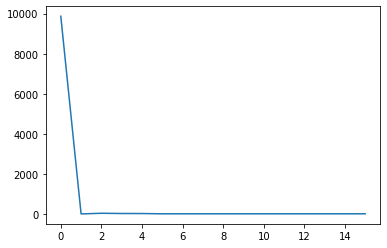

Opcion numero 2 (SHOP) con una variacion total de 8.370272877904465e+23%
[51.7647013944738, 66.67962704658996, 135.8710899575466, 31.244667505859102, 188.93893091339595, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096]


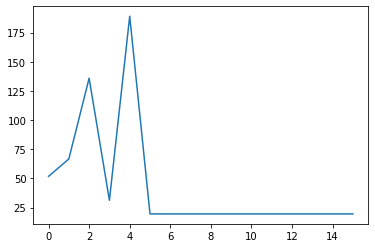

Opcion numero 3 (SUM) con una variacion total de 6.96577228985275e+23%
[40233.29349046558, 19.788522270662238, 31.790657435988212, -61.16505010956651, 89.83319562246072, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096]


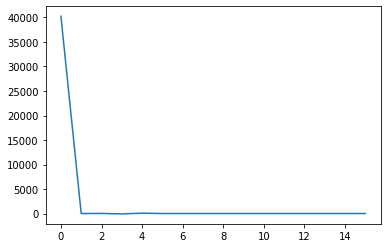

Opcion numero 4 (FIVN) con una variacion total de 6.782294301602955e+23%
[93.7639254511262, 71.99999491373697, 75.33474204721958, 82.54697214187999, 53.97981121413511, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096]


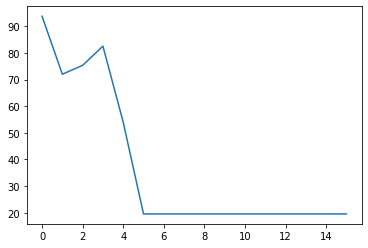

Opcion numero 5 (AMRN) con una variacion total de 6.104963383161007e+23%
[67.25663660799142, 70.1657470207556, 29.773473795058322, 220.99057526807468, 64.79631173611679, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096]


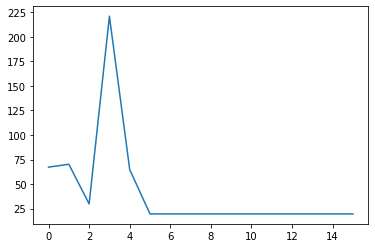

Opcion numero -1 (DCAR) con una variacion total de 279611195952812.78%
[-77.43506396326826, -9.285711528492495, -19.047619948671887, -94.696969788192, -38.88889164836307, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096] 279611195952812.78


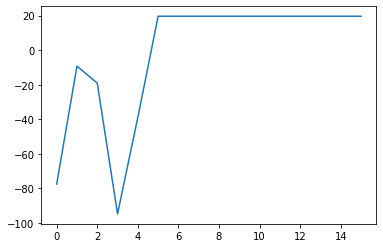

Opcion numero -2 (MOSY) con una variacion total de 279611195952812.78%
[-41.39784946236559, -80.0, -57.30769084050105, -84.95575204434434, -47.94117849178375, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096] 279611195952812.78


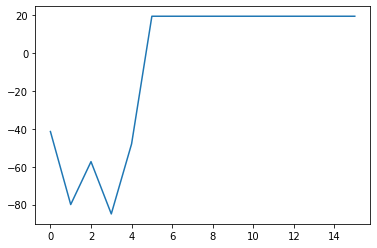

Opcion numero -3 (BLIN) con una variacion total de 279611195952812.78%
[-53.47826086956522, -39.62264150943396, -26.36363636363636, -90.68825910931172, -87.16666698455809, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096] 279611195952812.78


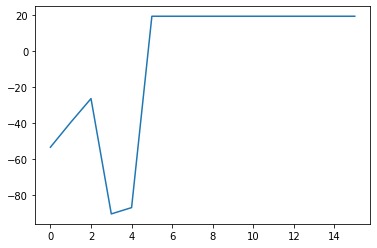

Opcion numero -4 (RGSE) con una variacion total de 279611195952812.78%
[-94.27272727272728, -98.15384620275252, -80.26666641235352, -61.4814835745938, -82.69230636971938, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096] 279611195952812.78


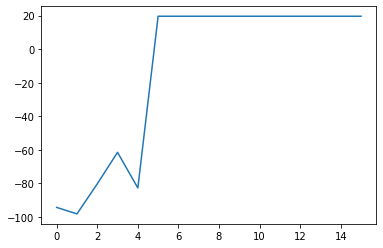

Opcion numero -5 (SUNW) con una variacion total de 279611195952812.78%
[-20.498494928705394, -45.79945783448807, -46.99646568990296, -76.39639644891942, -40.47618777303186, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096, 19.57420873072096] 279611195952812.78


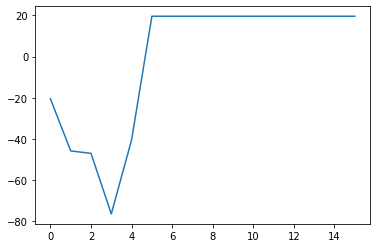

In [ ]:
mejores = cambio.keys()
mejores = sorted(mejores, key=lambda x: cambio[x], reverse=True)
#mejores
for i, k in enumerate(mejores[:5]):
    print(f'Opcion numero {i+1} ({k}) con una variacion total de {cambio[k]}%')
    print(res[k][1:])
    plt.plot(res[k][1:])
    plt.show()
for i, k in enumerate(mejores[-5:]):
    print(f'Opcion numero -{i+1} ({k}) con una variacion total de {cambio[k]}%')
    print(res[k][1:], cambio[k])
    plt.plot(res[k][1:])
    plt.show()

Según nuestro super-predictor, la mejor acción para comprar sería PEN. Sin embargo, si revisamos bien, estamos prediciendo siempre el mismo valor. La verdad tampoco es para sorprenderse, de haber funcionado bien ya seriamos todos millonarios y la bolsa de valores sería inútil.

# Extra (antes de M1)
Busqueda de columnas interesantes.

Vamos a basarnos en la idea de que si una caracteristica tiene muchos outliers no es una buena caracteristica para las predicciones que vamos a ver despues.

In [ ]:
data = {}
for i in range(2014, 2019):
    data[i] = pd.read_csv(f'{i}_Financial_data.csv')

outliers = defaultdict(int)
cant = defaultdict(int)
for y in range(2014, 2018):
    for k in pos[:-1]:
        d = data[y][k]
        cant[k] += int(d.describe()['count'])
        Q1 = d.quantile(0.25)
        Q3 = d.quantile(0.75)
        R = Q3 - Q1
        outliers[k] += ((d < (Q1 - 1.5*R)) | (d > (Q3 + 1.5*R))).sum()

In [ ]:
min(cant.values()), max(cant.values())

(13, 16732)

Vamos a elegir las caracteristicas que tienen una mayor cantidad de espacios blancos y tienen la menor cantidad de outliers

In [ ]:
finales = set()
while len(outliers) > 0 and len(finales) < 40:
    k = min(outliers.keys(), key=lambda x: outliers[x])
    if cant[k] > 16732*.96:
        print(k, outliers[k])
        finales.add(k)
    del outliers[k]
print(len(finales))

Gross Margin 99
Stock-based compensation 2073
EPS Diluted 2077
EPS 2078
Weighted Average Shs Out 2123
Operating Expenses 2253
SG&A Expense 2306
Total debt 2340
Gross Profit 2346
Depreciation & Amortization 2353
Interest Expense 2373
Cost of Revenue 2384
Cash and cash equivalents 2406
Revenue 2421
Total liabilities 2421
Total assets 2424
Total shareholders equity 2439
Receivables 2463
EBITDA 2472
Capital Expenditure 2536
Operating Cash Flow 2562
Payables 2578
Property, Plant & Equipment Net 2619
EBIT Margin 2686
Investing Cash flow 2696
EBIT 2711
Operating Income 2723
Goodwill and Intangible Assets 2731
Earnings before Tax 2920
Consolidated Income 2927
Net Profit Margin 2944
Net Income 2957
Earnings Before Tax Margin 2959
Free Cash Flow 3009
Net Income Com 3010
Income Tax Expense 3221
Retained earnings (deficit) 3442
Other comprehensive income 3837
Net cash flow / Change in cash 4222
Effect of forex changes on cash 4403
40


Vamos a revisar la informacion y quedarnos con las features que estan "mejor" distribuidas, esto nos deberia ayudar despues para hacer las clasificaciones. 

Earnings Before Tax Margin
count    16541.000000
mean        -7.876863
std        235.991483
min     -24202.000000
25%         -0.023400
50%          0.059300
75%          0.175300
max        198.118400
Name: Earnings Before Tax Margin, dtype: float64
normalized std: 29.960082974915558
percentile skewness: 0.4260070052539404


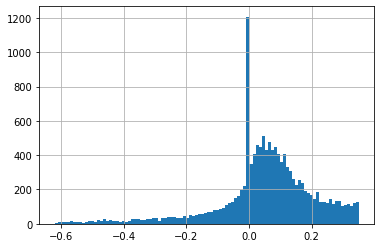


Income Tax Expense
count    1.623700e+04
mean     1.318859e+08
std      8.936194e+09
min     -7.380000e+11
25%      0.000000e+00
50%      3.646000e+06
75%      4.571100e+07
max      8.490000e+11
Name: Income Tax Expense, dtype: float64
normalized std: 67.75702462455278
percentile skewness: 32.83557836259316


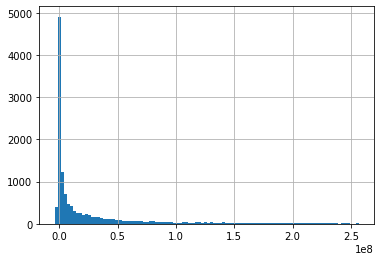


SG&A Expense
count    1.618200e+04
mean     8.619433e+08
std      3.840864e+09
min     -1.043667e+08
25%      1.701228e+07
50%      7.757000e+07
75%      3.561532e+08
max      1.856830e+11
Name: SG&A Expense, dtype: float64
normalized std: 4.456051421342917
percentile skewness: 18.8560088319666


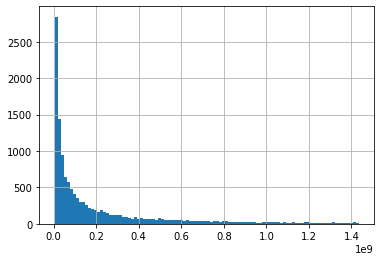


Stock-based compensation
count    1.613600e+04
mean     2.910986e+07
std      1.951887e+08
min     -1.370000e+08
25%      4.370000e+05
50%      3.532500e+06
75%      1.408525e+07
max      7.679000e+09
Name: Stock-based compensation, dtype: float64
normalized std: 6.705244100772778
percentile skewness: 11.911494008096248


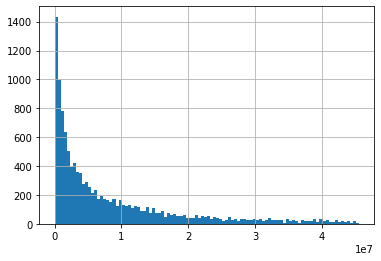


Property, Plant & Equipment Net
count    1.619500e+04
mean     2.744766e+09
std      1.900103e+10
min      0.000000e+00
25%      8.651796e+06
50%      9.306600e+07
75%      8.546095e+08
max      9.723130e+11
Name: Property, Plant & Equipment Net, dtype: float64
normalized std: 6.92264209018573
percentile skewness: 45.7030356462334


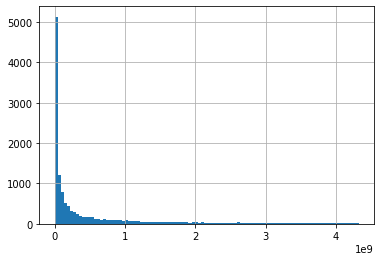


Net Income
count    1.627100e+04
mean     3.733851e+08
std      2.764139e+09
min     -2.304500e+10
25%     -8.525000e+06
50%      1.740000e+07
75%      1.489555e+08
max      2.339970e+11
Name: Net Income, dtype: float64
normalized std: 7.402915928762996
percentile skewness: 9.658898103782933


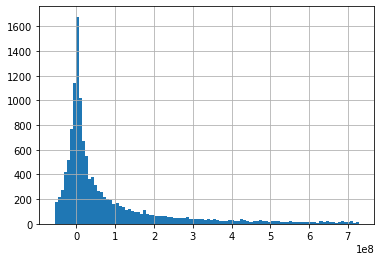


EPS
count    1.644900e+04
mean    -1.344259e+04
std      1.007070e+06
min     -1.018709e+08
25%     -3.900000e-01
50%      6.300000e-01
75%      1.950000e+00
max      8.028004e+06
Name: EPS, dtype: float64
normalized std: 74.9163340770086
percentile skewness: 1.0476398713826374


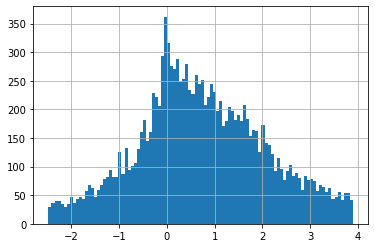


Cash and cash equivalents
count    1.655500e+04
mean     1.757878e+09
std      1.895739e+10
min      0.000000e+00
25%      1.660950e+07
50%      7.016000e+07
75%      2.855945e+08
max      9.620000e+11
Name: Cash and cash equivalents, dtype: float64
normalized std: 10.784248056054091
percentile skewness: 17.269383844355144


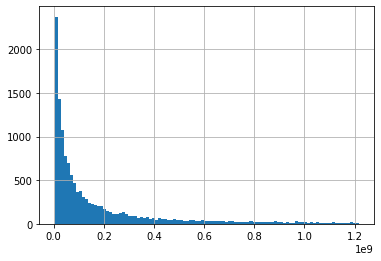


Interest Expense
count    1.615000e+04
mean     9.717823e+07
std      5.267661e+08
min     -1.710954e+09
25%      0.000000e+00
50%      3.265000e+06
75%      4.685500e+07
max      3.152300e+10
Name: Interest Expense, dtype: float64
normalized std: 5.4206186951100195
percentile skewness: 58.91053598774886


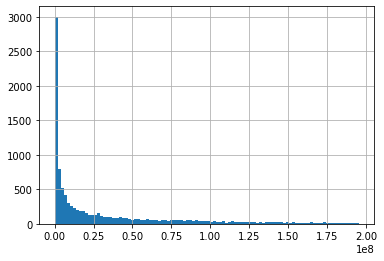


Receivables
count    1.661800e+04
mean     9.068245e+08
std      6.990348e+09
min      0.000000e+00
25%      2.059181e+06
50%      3.926150e+07
75%      2.730695e+08
max      4.150000e+11
Name: Receivables, dtype: float64
normalized std: 7.70860136655647
percentile skewness: 31.4560444505605


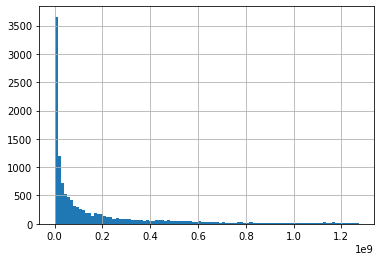


Total shareholders equity
count    1.643700e+04
mean     3.636401e+09
std      2.084127e+10
min     -2.288400e+10
25%      6.826500e+07
50%      3.450590e+08
75%      1.535800e+09
max      1.465725e+12
Name: Total shareholders equity, dtype: float64
normalized std: 5.731289211101021
percentile skewness: 17.617766757368777


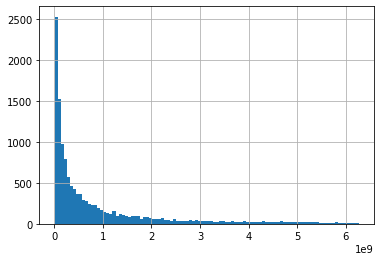


EBITDA
count    1.611400e+04
mean     9.142490e+08
std      4.608588e+09
min     -1.648400e+10
25%      1.580864e+06
50%      6.809550e+07
75%      3.933750e+08
max      2.337210e+11
Name: EBITDA, dtype: float64
normalized std: 5.040845432562149
percentile skewness: 17.98554357018333


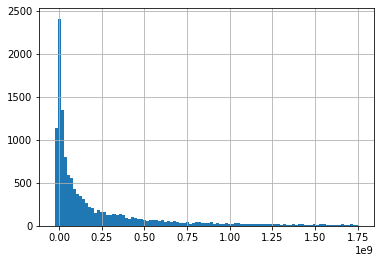


Retained earnings (deficit)
count    1.653900e+04
mean     2.079271e+09
std      1.505401e+10
min     -2.800000e+11
25%     -1.044298e+08
50%      1.713200e+07
75%      5.099705e+08
max      7.180000e+11
Name: Retained earnings (deficit), dtype: float64
normalized std: 7.240044640311043
percentile skewness: 7.431593876742758


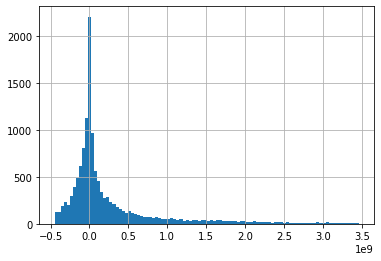


Consolidated Income
count    1.626900e+04
mean     3.859023e+08
std      2.785816e+09
min     -2.304500e+10
25%     -8.520000e+06
50%      1.845700e+07
75%      1.572170e+08
max      2.339970e+11
Name: Consolidated Income, dtype: float64
normalized std: 7.218967894628574
percentile skewness: 9.920126694673788


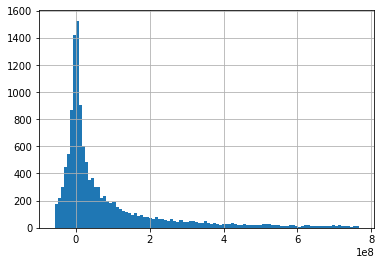


Operating Expenses
count    1.616700e+04
mean     1.351263e+09
std      5.697170e+09
min     -5.495512e+09
25%      3.404350e+07
50%      1.500680e+08
75%      6.045940e+08
max      3.056050e+11
Name: Operating Expenses, dtype: float64
normalized std: 4.21618162096711
percentile skewness: 15.869801304063763


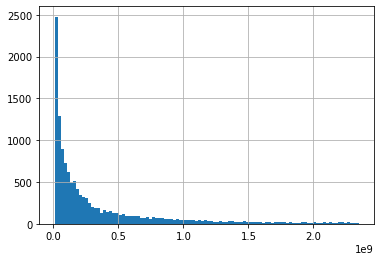


Gross Margin
count    16537.000000
mean         0.485343
std          1.019607
min        -74.319100
25%          0.250000
50%          0.459400
75%          0.801700
max         31.000000
Name: Gross Margin, dtype: float64
normalized std: 2.100797568551053
percentile skewness: 1.5179423822092437


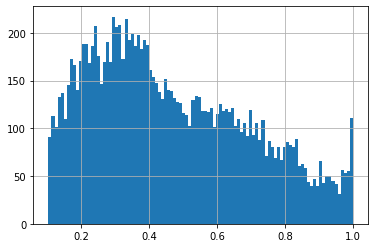


Cost of Revenue
count    1.609900e+04
mean     3.288256e+09
std      2.796652e+10
min     -2.986888e+09
25%      3.150944e+06
50%      1.465030e+08
75%      1.158607e+09
max      1.581527e+12
Name: Cost of Revenue, dtype: float64
normalized std: 8.504968507718774
percentile skewness: 34.65729029439672


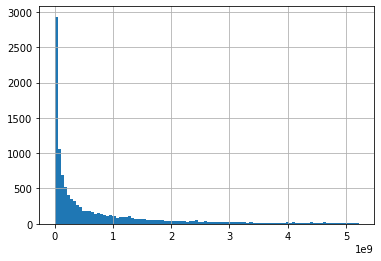


Operating Cash Flow
count    1.657500e+04
mean     1.111639e+09
std      1.737252e+10
min     -3.180000e+11
25%      1.217680e+06
50%      5.477700e+07
75%      3.179000e+08
max      9.600000e+11
Name: Operating Cash Flow, dtype: float64
normalized std: 15.627852178177031
percentile skewness: 17.851195149975347


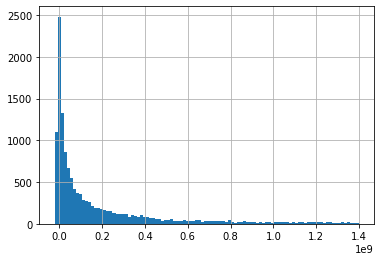


Investing Cash flow
count    1.640600e+04
mean    -7.047293e+08
std      5.061084e+09
min     -1.820000e+11
25%     -2.937188e+08
50%     -4.981850e+07
75%     -2.031000e+06
max      1.445908e+11
Name: Investing Cash flow, dtype: float64
normalized std: 7.181600993649767
percentile skewness: 0.0452075118959374


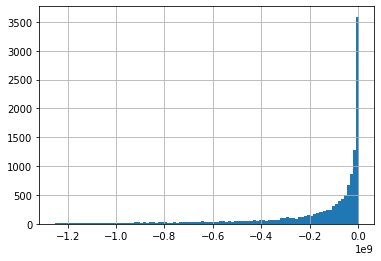


Goodwill and Intangible Assets
count    1.639000e+04
mean     1.678888e+09
std      8.565680e+09
min      0.000000e+00
25%      0.000000e+00
50%      3.292800e+07
75%      4.644000e+08
max      3.861800e+11
Name: Goodwill and Intangible Assets, dtype: float64
normalized std: 5.101996350783733
percentile skewness: 85.2116405490768


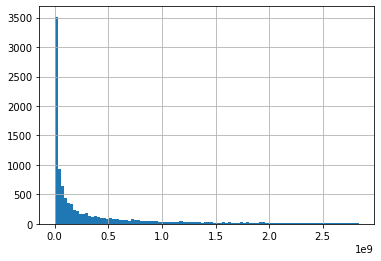


EPS Diluted
count    1.645600e+04
mean    -1.354125e+04
std      1.006232e+06
min     -1.018709e+08
25%     -3.900000e-01
50%      6.200000e-01
75%      1.915800e+00
max      6.624003e+06
Name: EPS Diluted, dtype: float64
normalized std: 74.30859388639583
percentile skewness: 1.0256410256410255


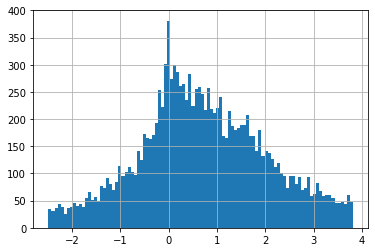


Total assets
count    1.648800e+04
mean     2.068250e+10
std      2.002779e+11
min      0.000000e+00
25%      1.971808e+08
50%      1.128730e+09
75%      5.117082e+09
max      2.035703e+13
Name: Total assets, dtype: float64
normalized std: 9.68344449655113
percentile skewness: 19.440184216536576


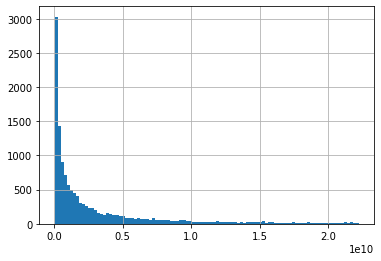


Gross Profit
count    1.654200e+04
mean     1.951222e+09
std      8.991122e+09
min     -1.280800e+10
25%      2.911375e+07
50%      1.871260e+08
75%      8.535505e+08
max      4.621600e+11
Name: Gross Profit, dtype: float64
normalized std: 4.607944822829083
percentile skewness: 17.363407660701018


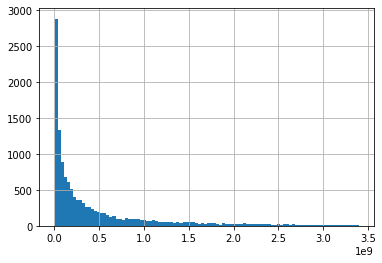


Operating Income
count    1.661900e+04
mean     5.728082e+08
std      2.978175e+09
min     -1.933900e+10
25%     -4.204410e+06
50%      3.410353e+07
75%      2.461665e+08
max      1.565540e+11
Name: Operating Income, dtype: float64
normalized std: 5.1992530035444755
percentile skewness: 14.69659433497407


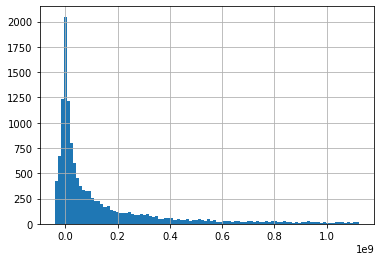


Net Profit Margin
count    16139.000000
mean        -7.923216
std        239.380809
min     -24414.000000
25%         -0.025900
50%          0.043600
75%          0.134136
max        156.461538
Name: Net Profit Margin, dtype: float64
normalized std: 30.21258114843243
percentile skewness: 0.341961679989849


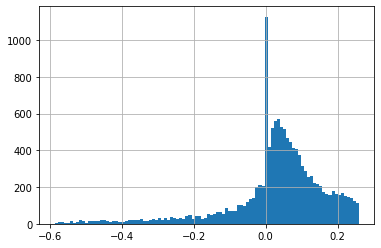


EBIT Margin
count    16185.000000
mean        -7.893454
std        238.754885
min     -24242.000000
25%          0.000000
50%          0.082100
75%          0.212100
max        190.076923
Name: EBIT Margin, dtype: float64
normalized std: 30.247199029219313
percentile skewness: 0.47655748233782913


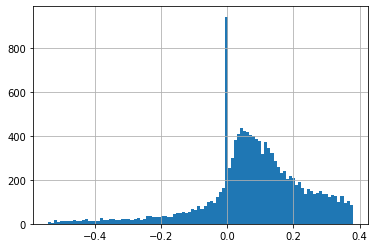


Free Cash Flow
count    1.621300e+04
mean     4.395332e+08
std      3.193202e+09
min     -1.042394e+11
25%     -9.839000e+06
50%      1.690365e+07
75%      1.652000e+08
max      9.887000e+10
Name: Free Cash Flow, dtype: float64
normalized std: 7.264983660622404
percentile skewness: 8.418857482401753


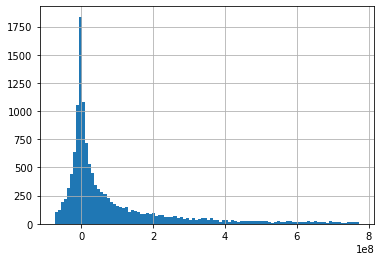


EBIT
count    1.640300e+04
mean     6.021199e+08
std      3.451918e+09
min     -1.871300e+10
25%     -3.743659e+06
50%      3.598400e+07
75%      2.564735e+08
max      2.339970e+11
Name: EBIT, dtype: float64
normalized std: 5.7329409164771175
percentile skewness: 15.228765630675037


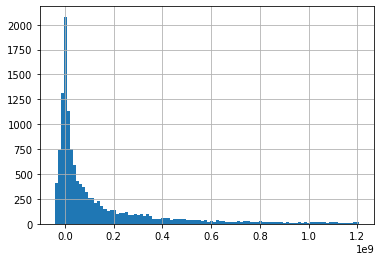


Net cash flow / Change in cash
count    1.669100e+04
mean     2.859670e+07
std      2.663943e+10
min     -9.880000e+11
25%     -1.521600e+07
50%      7.960000e+05
75%      2.986950e+07
max      9.880000e+11
Name: Net cash flow / Change in cash, dtype: float64
normalized std: 931.5559286555326
percentile skewness: 1.4767530661981312


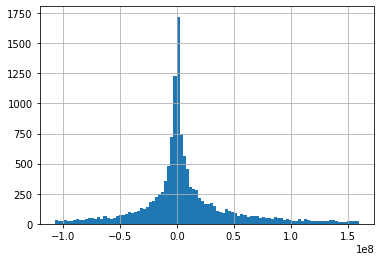


Capital Expenditure
count    1.630600e+04
mean    -3.981788e+08
std      2.745575e+09
min     -1.455850e+11
25%     -1.273710e+08
50%     -1.659300e+07
75%     -1.313000e+06
max      5.822595e+09
Name: Capital Expenditure, dtype: float64
normalized std: 6.895330636139617
percentile skewness: 0.02801412115468873


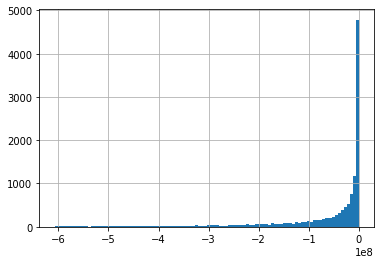


Earnings before Tax
count    1.639200e+04
mean     4.751175e+08
std      2.441642e+09
min     -1.910900e+10
25%     -8.440250e+06
50%      2.300000e+07
75%      1.867792e+08
max      8.720500e+10
Name: Earnings before Tax, dtype: float64
normalized std: 5.139027796916653
percentile skewness: 12.073576054519899


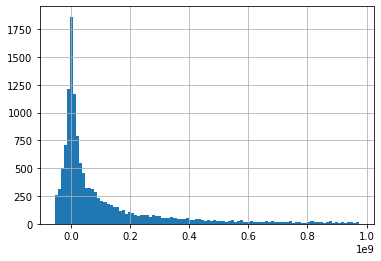


Other comprehensive income
count    1.616700e+04
mean     1.055596e+11
std      1.343713e+13
min     -8.409300e+10
25%     -1.950000e+07
50%     -1.750000e+05
75%      0.000000e+00
max      1.708525e+15
Name: Other comprehensive income, dtype: float64
normalized std: 127.29424763909405
percentile skewness: 0.018912757384081456


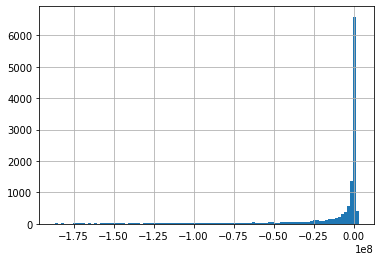


Effect of forex changes on cash
count    1.606500e+04
mean     5.345830e+06
std      8.815077e+09
min     -5.720000e+11
25%     -2.140000e+05
50%      0.000000e+00
75%      0.000000e+00
max      9.260000e+11
Name: Effect of forex changes on cash, dtype: float64
normalized std: 1648.9631018573987
percentile skewness: 0.14915000000000075


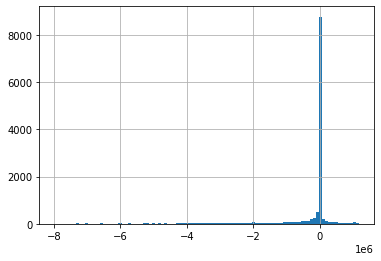


Revenue
count    1.656000e+04
mean     5.172728e+09
std      3.435646e+10
min     -6.276160e+08
25%      5.677500e+07
50%      4.239212e+08
75%      2.235000e+09
max      1.886894e+12
Name: Revenue, dtype: float64
normalized std: 6.641845790353617
percentile skewness: 21.356462934326053


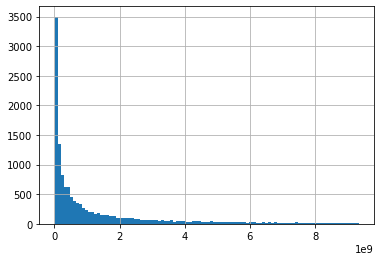


Total liabilities
count    1.641600e+04
mean     1.639195e+10
std      1.804575e+11
min     -6.750151e+09
25%      6.743975e+07
50%      6.173455e+08
75%      3.300355e+09
max      1.856536e+13
Name: Total liabilities, dtype: float64
normalized std: 11.008909905617777
percentile skewness: 22.863706956568308


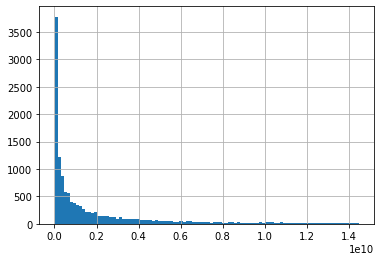


Payables
count    1.618900e+04
mean     9.269363e+08
std      9.008792e+09
min     -2.058635e+10
25%      2.658637e+06
50%      2.502300e+07
75%      1.767570e+08
max      4.242690e+11
Name: Payables, dtype: float64
normalized std: 9.718890445050425
percentile skewness: 37.2783838868242


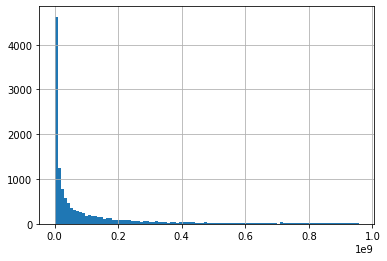


Net Income Com
count    1.641100e+04
mean     3.711694e+08
std      2.755154e+09
min     -2.304500e+10
25%     -9.197646e+06
50%      1.683500e+07
75%      1.478590e+08
max      2.339970e+11
Name: Net Income Com, dtype: float64
normalized std: 7.422902943238925
percentile skewness: 9.469149821091408


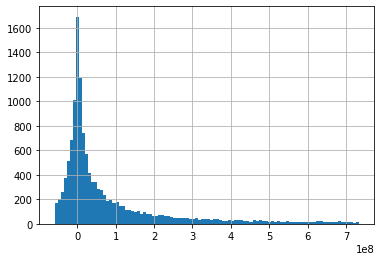


Weighted Average Shs Out
count    1.625700e+04
mean     2.621989e+08
std      2.051678e+09
min      0.000000e+00
25%      1.677013e+07
50%      4.300000e+07
75%      1.158548e+08
max      1.112919e+11
Name: Weighted Average Shs Out, dtype: float64
normalized std: 7.82489322387941
percentile skewness: 8.388679540166851


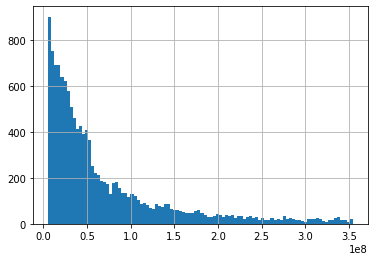


Depreciation & Amortization
count    1.630300e+04
mean     3.495708e+08
std      6.105453e+09
min     -8.336000e+07
25%      1.972000e+06
50%      1.980700e+07
75%      1.212960e+08
max      7.510000e+11
Name: Depreciation & Amortization, dtype: float64
normalized std: 17.465567831081867
percentile skewness: 24.535789498386894


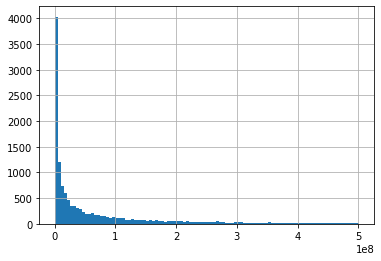


Total debt
count    1.614500e+04
mean     4.632549e+09
std      4.411780e+10
min     -9.289865e+09
25%      5.338000e+06
50%      2.036810e+08
75%      1.456959e+09
max      4.412529e+12
Name: Total debt, dtype: float64
normalized std: 9.523437480679465
percentile skewness: 29.656918416543526


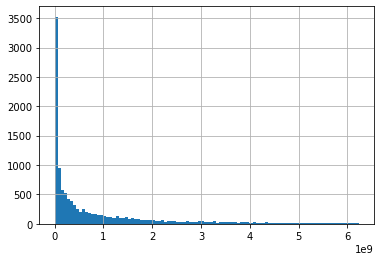

In [ ]:
delta = 0.1
for k in finales:
    print(k)
    df =  pd.concat([data[2014][k], data[2015][k], data[2016][k], data[2017][k]])
    info = df.describe()
    print(info)    
    print(f'normalized std: {info["std"] / abs(info["mean"])}')
    print(f'percentile skewness: {(df.quantile(.9)-df.quantile(.5))/(df.quantile(.5) - df.quantile(.1))}')
    q_low = df.quantile(delta)
    q_hi  = df.quantile(1-delta)
    df[(df < q_hi) & (df > q_low)].hist(bins=100)
    plt.show()
    print()
    

Net cash flow / Change in cash
count    4.084000e+03
mean     2.668020e+08
std      2.917673e+10
min     -6.720000e+11
25%     -2.002925e+07
50%      9.650000e+04
75%      2.166716e+07
max      9.880000e+11
Name: Net cash flow / Change in cash, dtype: float64
normalized std: 9.523437480679465
percentile skewness: 1.081876980747427


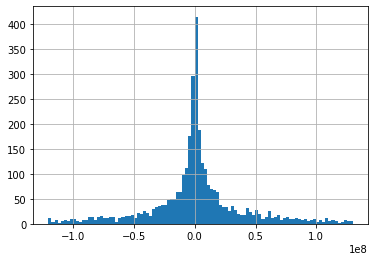


EPS Diluted
count    4.030000e+03
mean    -2.335794e+04
std      1.212367e+06
min     -7.534036e+07
25%     -5.000000e-01
50%      5.800000e-01
75%      1.820000e+00
max      1.343348e+03
Name: EPS Diluted, dtype: float64
normalized std: 9.523437480679465
percentile skewness: 0.8140957446808508


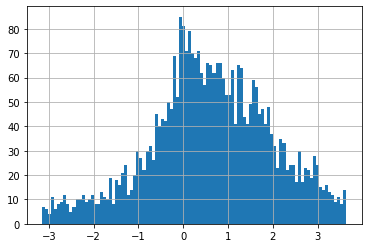


Weighted Average Shs Out
count    4.003000e+03
mean     2.590582e+08
std      2.076529e+09
min      0.000000e+00
25%      1.635573e+07
50%      4.191980e+07
75%      1.123737e+08
max      1.053903e+11
Name: Weighted Average Shs Out, dtype: float64
normalized std: 9.523437480679465
percentile skewness: 8.47704406050459


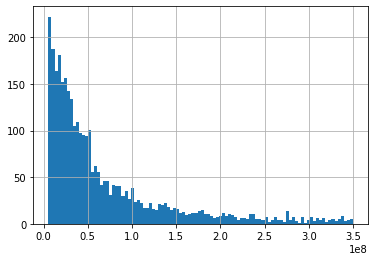


Net Income
count    3.955000e+03
mean     3.258953e+08
std      2.294821e+09
min     -1.456700e+10
25%     -1.026554e+07
50%      1.539500e+07
75%      1.367630e+08
max      8.654900e+10
Name: Net Income, dtype: float64
normalized std: 9.523437480679465
percentile skewness: 7.9661060063950915


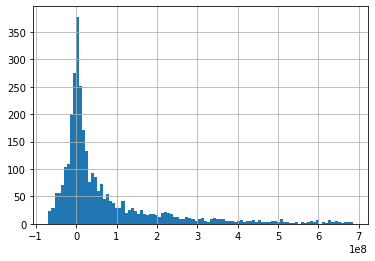


Gross Margin
count    4047.000000
mean        0.471515
std         1.432205
min       -74.319100
25%         0.248150
50%         0.464500
75%         0.805100
max         2.192400
Name: Gross Margin, dtype: float64
normalized std: 9.523437480679465
percentile skewness: 1.438047156130834


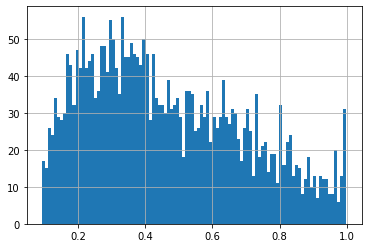


EPS
count    4.024000e+03
mean    -2.339272e+04
std      1.213270e+06
min     -7.534036e+07
25%     -5.000000e-01
50%      5.900000e-01
75%      1.850000e+00
max      1.343348e+03
Name: EPS, dtype: float64
normalized std: 9.523437480679465
percentile skewness: 0.8242488699813881


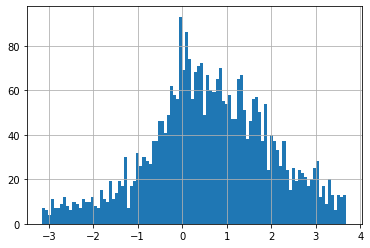


Net Profit Margin
count    3929.000000
mean      -11.232131
std       247.944953
min     -9704.666600
25%        -0.033700
50%         0.042000
75%         0.130400
max        21.009700
Name: Net Profit Margin, dtype: float64
normalized std: 9.523437480679465
percentile skewness: 0.27112143192610766


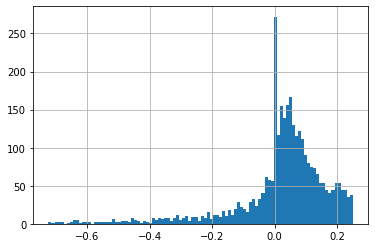


EBIT Margin
count    3946.000000
mean      -11.486417
std       249.688662
min     -9626.000000
25%        -0.008275
50%         0.078350
75%         0.203500
max        14.154900
Name: EBIT Margin, dtype: float64
normalized std: 9.523437480679465
percentile skewness: 0.37491919844861027


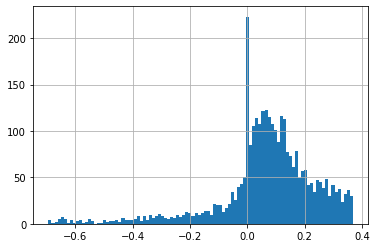


Consolidated Income
count    3.954000e+03
mean     3.363523e+08
std      2.322753e+09
min     -1.463500e+10
25%     -1.045098e+07
50%      1.598350e+07
75%      1.431890e+08
max      8.654900e+10
Name: Consolidated Income, dtype: float64
normalized std: 9.523437480679465
percentile skewness: 8.099384341645449


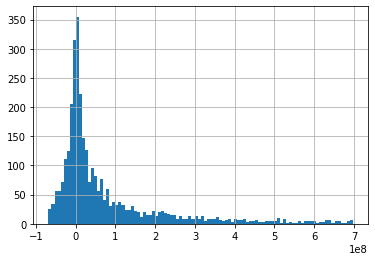


Sector
count                   4120
unique                    11
top       Financial Services
freq                     769
Name: Sector, dtype: object


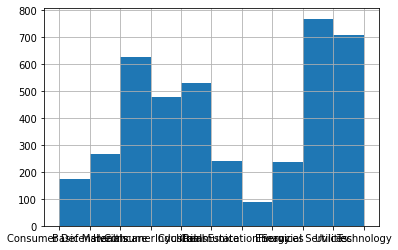

In [ ]:
revisar = ['Net cash flow / Change in cash','EPS Diluted','Weighted Average Shs Out','Net Income','Gross Margin','EPS','Net Profit Margin','EBIT Margin','Consolidated Income', 'Sector']
delta = 0.1
for k in revisar:
    print(k)
    df = data[2015][k]
    print(df.describe())
    if k == 'Sector':
        df.hist()
        plt.show()
        continue
    print(f'normalized std: {info["std"] / abs(info["mean"])}')
    print(f'percentile skewness: {(df.quantile(.9)-df.quantile(.5))/(df.quantile(.5) - df.quantile(.1))}')
    q_low = df.quantile(delta)
    q_hi  = df.quantile(1-delta)
    df[(df < q_hi) & (df > q_low)].hist(bins=100)
    plt.show()
    print()

Nos vamos a quedar con:
- Net cash flow / Change in cash
- EPS Diluted
- Weighted Average Shs Out
- Net Income
- Gross Margin
- EPS
- Net Profit Margin
- EBIT Margin
- Consolidated Income
- Sector